In [1]:
import os
path_project = os.path.dirname(os.path.abspath('.'))
import sys
sys.path.append(os.path.join(path_project, 'src'))
sys.path.append(os.path.join(path_project, 'exp/script'))
import results_saver
import options
import copy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import subprocess
import re

img_path = os.path.join(path_project, 'exp', 'img')
results_path = os.path.join(path_project, 'exp', 'results')
default_args = options.build_default_args(path_project)

PLOT_MARKERS = ['o', 'v', 's', 'X', 'p', '*', 'h', '^', '<', '>', 'H', 'D', 'd', 'P']
METHOD_ORDER = ["DEFAULT", "ULDP-NAIVE", "ULDP-GROUP-2", "ULDP-GROUP-8", "ULDP-SGD", "ULDP-AVG"]

This notebook can visualize the all of experimental results.


All experiments are identified and named by hash made from all of arguments for `src/run_simulation.py`. (see `args_to_hash` in `src/results_saver.py` in detail.)

In [2]:
marker_size = 2
alpha = 0.9
import glob

def load_result_from_file_path(file_path: str):
    with open(file_path, "r") as json_file:
        results = json.load(json_file)
    args = results["args"]
    print(args)
    return results["exp"]


def plot_multiple_epsilons(file_paths: list[str], setting_map: dict =None, title: str=None, img_file: str="", n_rounds: int=50, modified=True):
    n_files = len(file_paths)
    all_data = []
    for i, file_path in enumerate(file_paths):
        privacy_budget_list = load_result_from_file_path(file_path)
        privacy_result = None
        for privacy_budget in privacy_budget_list:
            if privacy_budget == "Assertion Error":
                print("[WARN] Assertion Error")
                continue
            elif privacy_budget == "LOSS IS NAN":
                print("[WARN] Loss is NAN")
                continue
            privacy_result = privacy_budget
        if privacy_result is None:
            print("[WARN] privacy_result is None")
            continue
            # raise ValueError("No privacy result")

        if privacy_result.get("privacy_info"):
            privacy_info = privacy_result["privacy_info"]
            print(setting_map[i], "group_k: ", privacy_info['group_k'])
            eps_list = compute_group_dp(privacy_info['group_k'], privacy_info['history'], final_delta=0.00001, n_rounds=n_rounds)
            all_data.append((i, eps_list))
        else:
            all_data.append((i, privacy_result["global"]["privacy_budget"]))

    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    if setting_map is None:
        setting_map = {i: i for i in range(n_files)}
    loss_metric_results = {"round_idx": [], "epsilon": [], "setting": []}
    for file_idx, result in all_data:
        for round_idx, epsilon, _  in result:
            loss_metric_results["round_idx"].append(round_idx)
            loss_metric_results["epsilon"].append(epsilon)
            loss_metric_results["setting"].append(setting_map[file_idx])

    modified_palette = sns.color_palette("colorblind")
    if modified:
        modified_palette = modified_palette[1:]
    sns.lineplot(
        x="round_idx",
        y="epsilon",
        hue="setting",
        style="setting",
        data=loss_metric_results,
        ax=ax,
        markers=PLOT_MARKERS,
        markersize=8,
        alpha=0.7,
        palette=modified_palette,
    )
    ax.set_xlabel("Round", fontsize=18)
    ax.set_ylabel("Epsilon (delta=0.00001)", fontsize=18)
    ax.set_yscale("log")
    ax.legend(fontsize=12)
    if title is not None:
        ax.set_title(title, fontsize=20)
    fig.savefig(
        os.path.join(img_path, "epsilon-" + img_file + ".png"),
        dpi=150,
        bbox_inches="tight",
    )


def plot_multiple_losses(file_paths: list[str], setting_map: dict =None, title: str=None, img_file: str=""):
    n_files = len(file_paths)
    all_data = []
    for i, file_path in enumerate(file_paths):
        exp_result_list = load_result_from_file_path(file_path)
        for exp_result in exp_result_list:
            if exp_result == "Assertion Error":
                print("[WARN] Assertion Error")
                continue
            elif exp_result == "LOSS IS NAN":
                print("[WARN] Loss is NAN")
                continue
            all_data.append((i, exp_result["global"]["global_test"]))
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    if setting_map is None:
        setting_map = {i: i for i in range(n_files)}
    loss_metric_results = {"round_idx": [], "test_loss": [], "setting": []}
    for file_idx, result in all_data:
        for round_idx, _, test_loss in result:
            loss_metric_results["round_idx"].append(round_idx)
            loss_metric_results["test_loss"].append(test_loss)
            loss_metric_results["setting"].append(setting_map[file_idx])

    sns.lineplot(
        x="round_idx",
        y="test_loss",
        hue="setting",
        data=loss_metric_results,
        ax=ax,
        marker='o',
        markersize=4,
        alpha=1.0,
        palette="colorblind",
    )
    ax.set_xlabel("Round", fontsize=18)
    ax.set_yscale("log")
    ax.set_ylabel("Test Loss", fontsize=18)
    ax.legend(fontsize=12)
    if title is not None:
        ax.set_title(title, fontsize=20)
    fig.savefig(
        os.path.join(img_path, "testloss-" + img_file + ".png"),
        dpi=150,
        bbox_inches="tight",
    )

def plot_multiple_metrics(file_paths: list[str], setting_map: dict =None, title: str=None, img_file: str=""):
    n_files = len(file_paths)
    all_data = []
    for i, file_path in enumerate(file_paths):
        exp_result_list = load_result_from_file_path(file_path)
        for exp_result in exp_result_list:
            if exp_result == "Assertion Error":
                print("[WARN] Assertion Error")
                continue
            elif exp_result == "LOSS IS NAN":
                print("[WARN] Loss is NAN")
                continue
            all_data.append((i, exp_result["global"]["global_test"]))
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    if setting_map is None:
        setting_map = {i: i for i in range(n_files)}
    loss_metric_results = {"round_idx": [], "test_metric": [], "setting": []}
    for file_idx, result in all_data:
        for round_idx, test_metric, _ in result:
            loss_metric_results["round_idx"].append(round_idx)
            loss_metric_results["test_metric"].append(test_metric)
            loss_metric_results["setting"].append(setting_map[file_idx])

    sns.lineplot(
        x="round_idx",
        y="test_metric",
        hue="setting",
        data=loss_metric_results,
        ax=ax,
        marker='o',
        markersize=4,
        alpha=1.0,
        palette="colorblind",
    )
    ax.set_xlabel("Round", fontsize=18)
    ax.set_ylabel("Metric", fontsize=18)
    ax.set_yscale("log")
    ax.legend(fontsize=12)
    if title is not None:
        ax.set_title(title, fontsize=20)
    fig.savefig(
        os.path.join(img_path, "metrics-" + img_file + ".png"),
        dpi=150,
        bbox_inches="tight",
    )

def get_file_path_from_hash(hash_val):
    files = glob.glob(os.path.join(results_path, hash_val, "*.json"))
    # for f_path in files:
        # print(f_path)
    return files

def extract_hash_from_script(script_name):
    script_path = f"{path_project}/exp/script/{script_name}.sh"
    process = subprocess.Popen(["bash", script_path, "--dry_run"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    stdout = stdout.decode("utf-8")
    stderr = stderr.decode("utf-8")
    print(stderr)
    hash_values = re.findall(r'Hash value:\s+([a-f0-9]+)', stdout)
    return hash_values

def get_result_files_of_script(script_name):
    hash_values = extract_hash_from_script(script_name)
    file_paths = []
    for i, h in enumerate(hash_values):
        files = get_file_path_from_hash(h)
        sorted_files = sorted(files)
        if len(sorted_files) > 0:
            file_paths.append(sorted_files[-1])
        else:
            print(f"No file found {i}-th file, hash: {h}")
    return file_paths


def compute_group_dp(group_k, history_list, final_delta, n_rounds=50):
    max_idx = np.argmax(
        [get_group_privacy_spent(group_k=group_k, accountant_history=history, delta=final_delta)[0] for _, history in history_list]
    )
    # print("max silo is: ", max_idx)
    history_of_max = history_list[max_idx][1]
    n_itr = history_of_max[0][-1]
    step_size = int(np.ceil(n_itr / n_rounds))
    eps_list = []
    for i, itr_so_far in enumerate(range(step_size, n_itr, step_size)):
        if i % 5 != 0:
            continue
        intermediate_history = copy.deepcopy(history_of_max)
        intermediate_history[0][-1] = itr_so_far
        eps, alpha = get_group_privacy_spent(group_k=group_k, accountant_history=intermediate_history, delta=final_delta)
        # eps, normal_delta = get_normal_group_privacy_spent(group_k=group_k, accountant_history=intermediate_history, delta=final_delta)
        eps_list.append((i, eps, alpha))

    eps, alpha = get_group_privacy_spent(group_k=group_k, accountant_history=history_of_max, delta=final_delta)
    # eps, normal_delta = get_normal_group_privacy_spent(group_k=group_k, accountant_history=history_of_max, delta=final_delta)
    eps_list.append((n_rounds-1, eps, alpha))
    return eps_list


from opacus.accountants.analysis import rdp as analysis
import warnings

def get_normal_group_privacy_spent(
    group_k: int, accountant_history: list, delta: float
) -> tuple[float, float]:
    log_final_delta = np.log(delta)
    if group_k == 1:
        eps, alpha = get_privacy_spent(delta=delta, history=accountant_history)
        return eps, delta
    # if group_k > 62:  # using sigma=5.0 and opacus accountant, group_k > 62 cannot compute 
    #     warnings.warn("GROUP-k is larger than 62, compute for group_k=62, which means fairly underestimate")
    #     print("GROUP-k is larger than 62, compute for group_k=62, which means fairly underestimate")
    #     group_k = 62

    upper = np.log(delta)
    lower = -1e20
    computed_delta = delta
    group_delta = lower
    accuracy = delta / 1e3
    first = True
    while np.abs(delta - group_delta) > accuracy:
        middle = (upper + lower) / 2.0
        eps, alpha = get_privacy_spent(
            log_delta=middle, history=accountant_history
        )
        group_esp, group_delta = convert_to_group_privacy(
            epsilon=eps, log_delta=middle, group_k=group_k
        )
        if first:
            if group_delta == np.inf:
                raise ValueError("Cannot compute group delta")
            first = False
        upper = middle if group_delta > delta else upper
        lower = middle if group_delta < delta else lower
    return group_esp, group_delta


def get_privacy_spent(*, history, delta: float = None, log_delta: float = None):
    DEFAULT_ALPHAS = [1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64))
    alphas = DEFAULT_ALPHAS
    rdp = sum(
        [
            analysis.compute_rdp(
                q=sample_rate,
                noise_multiplier=noise_multiplier,
                steps=num_steps,
                orders=alphas,
            )
            for (noise_multiplier, sample_rate, num_steps) in history
        ]
    )

    orders_vec = np.atleast_1d(alphas)
    rdp_vec = np.atleast_1d(rdp)

    if len(orders_vec) != len(rdp_vec):
        raise ValueError(
            f"Input lists must have the same length.\n"
            f"\torders_vec = {orders_vec}\n"
            f"\trdp_vec = {rdp_vec}\n"
        )

    if log_delta is None:
        eps = (
            rdp_vec
            - (np.log(delta) + np.log(orders_vec)) / (orders_vec - 1)
            + np.log((orders_vec - 1) / orders_vec)
        )
    else:
        eps = (
            rdp_vec
            - (log_delta + np.log(orders_vec)) / (orders_vec - 1)
            + np.log((orders_vec - 1) / orders_vec)
        )
    
    # special case when there is no privacy
    if np.isnan(eps).all():
        return np.inf, np.nan

    idx_opt = np.nanargmin(eps)  # Ignore NaNs
    if idx_opt == 0 or idx_opt == len(eps) - 1:
        extreme = "smallest" if idx_opt == 0 else "largest"
        warnings.warn(
            f"Optimal order is the {extreme} alpha. Please consider expanding the range of alphas to get a tighter privacy bound."
        )
    return eps[idx_opt], orders_vec[idx_opt]


def convert_to_group_privacy(
    epsilon: float, group_k: int, log_delta: float = None, delta: float = None
):
    if log_delta is None:
        return epsilon * group_k, group_k * np.exp(
            (group_k - 1) * epsilon + np.log(delta)
        )
    else:
        # print(group_k, epsilon, log_delta)
        # if np.exp((group_k - 1) * epsilon + log_delta) == np.inf:
            # raise ValueError("Cannot compute group delta")
        return epsilon * group_k, group_k * np.exp((group_k - 1) * epsilon + log_delta)

def get_group_privacy_spent(
    group_k: int, accountant_history: list, delta: float
) -> float:
    """
    Following Proposition 2 of RDP paper https://arxiv.org/pdf/1702.07476.pdf

    Returns:
        Pair of epsilon and optimal order alpha.
    """
    if not accountant_history:
        return 0.0

    if group_k > 0 and (group_k & (group_k - 1)) != 0:
        # return 0.0, 0.0
        # raise ValueError(
        #     "The group size must be a power of 2, but got group size = {}".format(
        #         group_k
        #     )
        # )
        new_k = int(2 ** (np.floor(np.log2(group_k))))
        print("The group size must be a power of 2, but got group size = {}, use group size = {}".format(group_k, new_k))
        group_k = new_k

    orders_vec = [group_k * 2 + x / 10.0 for x in range(0, 100)] + list(
        np.linspace(group_k + 10, group_k * 64, 20)
    )

    rdp_vec = sum(
        [
            analysis.compute_rdp(
                q=sample_rate,
                noise_multiplier=noise_multiplier,
                steps=num_steps,
                orders=orders_vec,
            )
            for (noise_multiplier, sample_rate, num_steps) in accountant_history
        ]
    )

    if len(orders_vec) != len(rdp_vec):
        raise ValueError(
            f"Input lists must have the same length.\n"
            f"\torders_vec = {orders_vec}\n"
            f"\trdp_vec = {rdp_vec}\n"
        )

    c = np.log2(group_k)
    group_rdp_vec = np.array([3**c * rdp for rdp in rdp_vec])
    group_orders_vec = np.array([a / group_k for a in orders_vec])

    eps = (
        group_rdp_vec
        - (np.log(delta) + np.log(group_orders_vec)) / (group_orders_vec - 1)
        + np.log((group_orders_vec - 1) / group_orders_vec)
    )

    # special case when there is no privacy
    if np.isnan(eps).all():
        return np.inf, np.nan

    idx_opt = np.nanargmin(eps)  # Ignore NaNs
    if idx_opt == 0 or idx_opt == len(eps) - 1:
        extreme = "smallest" if idx_opt == 0 else "largest"
        warnings.warn(
            f"Optimal order is the {extreme} alpha. Please consider expanding the range of alphas to get a tighter privacy bound."
        )
    return eps[idx_opt], orders_vec[idx_opt] * group_k


## Overhead of MPC
- heart_disease
- tcga_brca

### For medical data
- script: `script/secure_weighting.sh`

+++ dirname /Users/fumiyuki/research/AcSilo/acsilo/exp/script/secure_weighting.sh
++ cd /Users/fumiyuki/research/AcSilo/acsilo/exp/script
++ pwd -P
+ SCRIPT_PATH=/Users/fumiyuki/research/AcSilo/acsilo/exp/script
+ RUN_SIMULATION_PATH=/Users/fumiyuki/research/AcSilo/acsilo/exp/script/../../src/run_simulation.py
+ VERSION=0
+ TIMES=5
+ DRY_RUN=
+ for arg in '"$@"'
+ '[' --dry_run == --dry_run ']'
+ DRY_RUN=--dry_run
+ n_users_list=(10 100)
+ for n_users in '"${n_users_list[@]}"'
+ python /Users/fumiyuki/research/AcSilo/acsilo/exp/script/../../src/run_simulation.py --dataset_name=heart_disease --verbose=1 --agg_strategy=ULDP-AVG-w --n_users=10 --global_learning_rate=10.0 --clipping_bound=0.1 --n_total_round=3 --local_learning_rate=0.001 --local_epochs=50 --sigma=5.0 --user_dist=zipf --user_alpha=0.5 --silo_dist=zipf --silo_alpha=2.0 --times=5 --version=0 --dry_run --secure_w
+ for n_users in '"${n_users_list[@]}"'
+ python /Users/fumiyuki/research/AcSilo/acsilo/exp/script/../../src/run_si

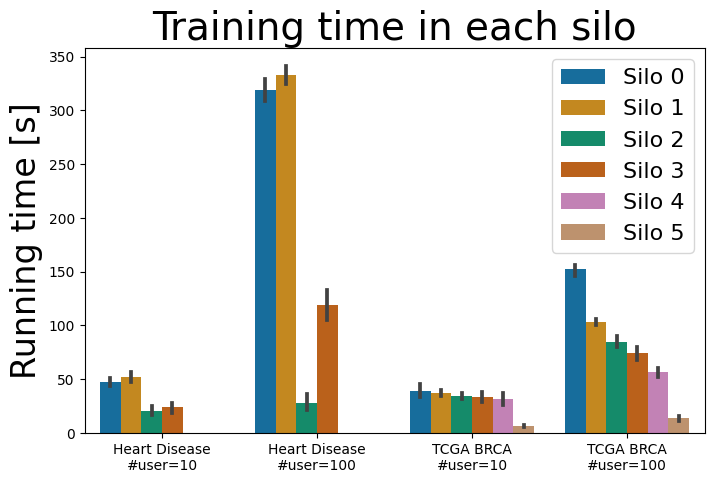

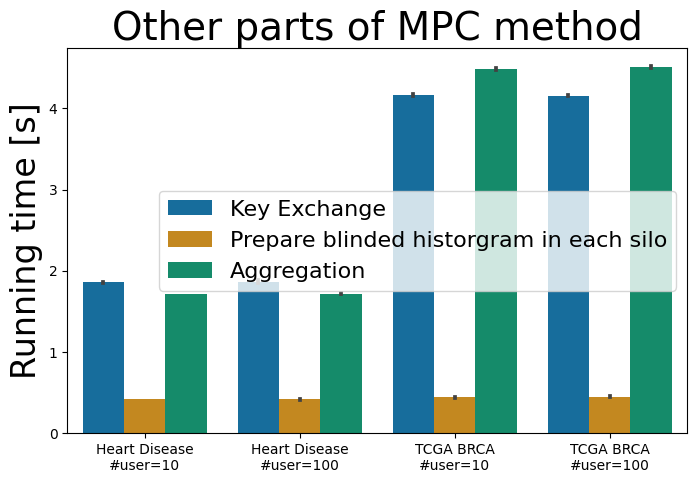

In [6]:
secure_weighting_file_paths = get_result_files_of_script("secure_weighting")
n_files = len(secure_weighting_file_paths)
all_data = []
for i, file_path in enumerate(secure_weighting_file_paths):
    exp_result_list = load_result_from_file_path(file_path)
    for exp_result in exp_result_list:
        diff_list = []
        previous_time =0
        for time in exp_result["time"]["time"]:
            diff_list.append(time*(-1) - previous_time)
            previous_time = time*(-1)
        exp_result["time"]["diff"] = diff_list
        all_data.append((i, exp_result["time"]))

setting_map = {0: "Heart Disease\n#user=10", 1: "Heart Disease\n#user=100", 2: "TCGA BRCA\n#user=10", 3: "TCGA BRCA\n#user=100"}

if setting_map is None:
    setting_map = {i: i for i in range(n_files)}
all_results = {"round_idx": [], "time": [], "kind": [], "counter": [], "setting": []}
kind_map = {"training_silo_0": "Silo 0", "training_silo_1": "Silo 1", "training_silo_2": "Silo 2", "training_silo_3": "Silo 3", "training_silo_4": "Silo 4", "training_silo_5": "Silo 5", "key_exchange": "Key Exchange", "multiplicative_blind_user_hist": "Prepare blinded historgram in each silo", "aggregation": "Aggregation"}
for file_idx, result in all_data:
    for round_idx, time, kind, counter  in zip(result["round_idx"], result["diff"], result["kind"], result["counter"]):
        all_results["round_idx"].append(round_idx)
        all_results["time"].append(time)
        all_results["kind"].append(kind)
        all_results["counter"].append(counter)
        all_results["setting"].append(setting_map[file_idx])

running_time_results = {"time": [], "kind": [], "setting": []}
other_time_results = {"time": [], "kind": [], "setting": []}
for time, kind, setting in zip(all_results['time'], all_results['kind'], all_results['setting']):
    if kind.startswith('training'):
        running_time_results['time'].append(time)
        running_time_results['kind'].append(kind_map[kind])
        running_time_results['setting'].append(setting)
    elif kind in ["key_exchange", "aggregation"]:
        other_time_results['time'].append(time)
        other_time_results['kind'].append(kind_map[kind])
        other_time_results['setting'].append(setting)
    elif kind in ["multiplicative_blind_user_hist"]:
        if setting.endswith("10"):
            n = 10
        elif setting.endswith("100"):
            n = 100
        other_time_results['time'].append(time / n)
        other_time_results['kind'].append(kind_map[kind])
        other_time_results['setting'].append(setting)


fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.barplot(
    x="setting",
    y="time",
    hue="kind",
    data=running_time_results,
    ax=ax,
    alpha=1.0,
    palette="colorblind",
)
ax.tick_params(axis='x', labelsize=12) 
ax.tick_params(axis='y', labelsize=14) 
ax.set_ylabel("Running time [s]", fontsize=24)
ax.set_title("Training time in each silo", fontsize=28)
ax.legend(fontsize=16)
fig.savefig(
    os.path.join(img_path, "private_weighting_medical_runtime_training.png"),
    dpi=150,
    bbox_inches="tight",
)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.barplot(
    x="setting",
    y="time",
    hue="kind",
    data=other_time_results,
    ax=ax,
    alpha=1.0,
    palette="colorblind",
)
ax.set_ylabel("Running time [s]", fontsize=24)
ax.set_title("Other parts of MPC method", fontsize=28)
ax.legend(fontsize=16)
fig.savefig(
    os.path.join(img_path, "private_weighting_medical_runtime_others.png"),
    dpi=150,
    bbox_inches="tight",
)
plt.show()

### For artificial data
- script: `secure_weighting.ipynb`

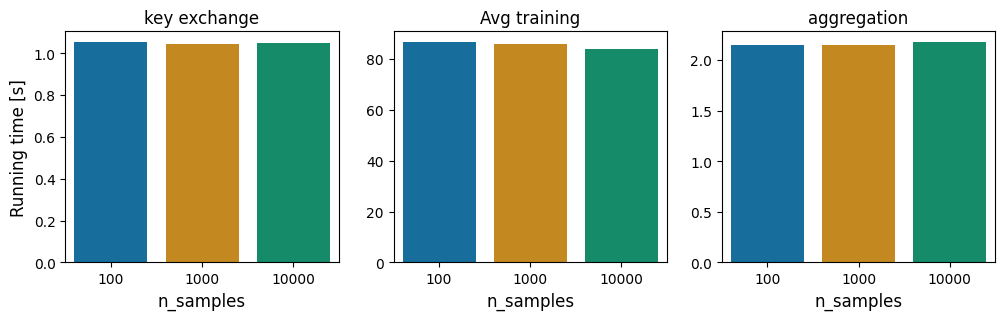

In [116]:
# For n_samples

n_samples_time_results = {"time": [], "kind": [], "n_samples": []}
n_samples_list = [100, 1000, 10000]
key_exchnage_list = [1.051577091217041, 1.0447149276733398, 1.0501000881195068]
# multiplicative_blind_user_hist_list = [4.12992000579834, 4.114915132522583, 4.100116968154907]
training_silo_list = [[85.44185900688171, 84.4896731376648, 89.13435697555542], [86.59528112411499, 83.68200397491455, 86.97076797485352], [85.51134705543518, 94.669105052948, 71.39624691009521]]
aggregation_list = [2.1517958641052246, 2.145372152328491, 2.1742188930511475]


for i in range(len(n_samples_list)):
    n_samples_time_results['time'].append(key_exchnage_list[i])
    n_samples_time_results['kind'].append('key exchange')
    n_samples_time_results['n_samples'].append(n_samples_list[i])

    # n_samples_time_results['time'].append(multiplicative_blind_user_hist_list[i])
    # n_samples_time_results['kind'].append('multiplicative blind user hist')
    # n_samples_time_results['n_samples'].append(n_samples_list[i])

    n_samples_time_results['time'].append(sum(training_silo_list[i])/len(training_silo_list[i]))
    n_samples_time_results['kind'].append('Avg training')
    n_samples_time_results['n_samples'].append(n_samples_list[i])

    n_samples_time_results['time'].append(aggregation_list[i])
    n_samples_time_results['kind'].append('aggregation')
    n_samples_time_results['n_samples'].append(n_samples_list[i])


# kinds = ["key exchange", "multiplicative blind user hist", "Avg training", "aggregation"]
kinds = ["key exchange", "Avg training", "aggregation"]

fig, axes = plt.subplots(1, len(kinds), figsize=(len(kinds)*4, 3))
for j, kind in enumerate(kinds):
    times = [n_samples_time_results['time'][i] for i in range(len(n_samples_time_results['kind'])) if n_samples_time_results['kind'][i] == kind]
    n_samples = [n_samples_time_results['n_samples'][i] for i in range(len(n_samples_time_results['kind'])) if n_samples_time_results['kind'][i] == kind]

    sns.barplot(x=n_samples, y=times, palette="colorblind", ax=axes[j])
    axes[j].set_xlabel("n_samples", fontsize=12)
    if j == 0:
        axes[j].set_ylabel("Running time [s]", fontsize=12)
    axes[j].set_title(f"{kind}", fontsize=12)
fig.savefig(
    os.path.join(img_path, "private_weighting_artificial_runtime_for_n_samples.png"),
    dpi=150,
    bbox_inches="tight",
)
plt.show()

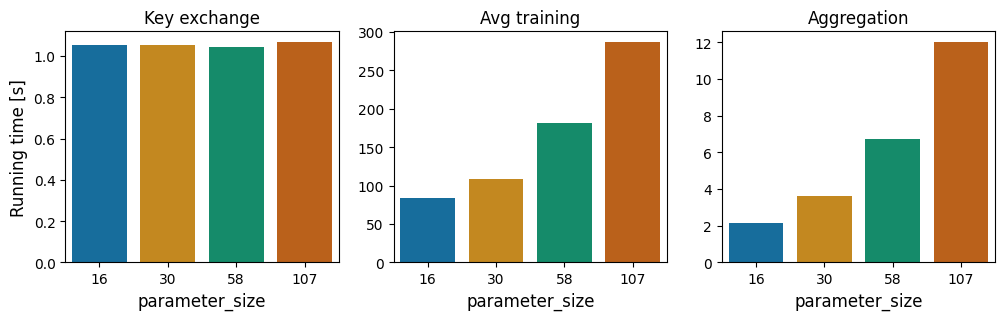

In [118]:
# For parameter_size

parameter_size_time_results = {"time": [], "kind": [], "parameter_size": []}
parameter_size_list = [16, 30, 58, 107]
key_exchnage_list = [1.051577091217041, 1.054563045501709, 1.044889211654663, 1.0656218528747559]
# multiplicative_blind_user_hist_list = [4.100116968154907/3, 4.218053817749023/3, 4.1281819343566895/3, 4.129354000091553/3]
training_silo_list = [[85.51134705543518, 94.669105052948, 71.39624691009521], [122.73623919487, 94.80184197425842, 107.45446586608887], [186.789489030838, 185.6517848968506, 172.2580258846283], [287.4782841205597, 303.5857400894165, 267.60097789764404]]
aggregation_list = [2.1742188930511475, 3.6276512145996094, 6.741549015045166, 11.992104053497314]


for i in range(len(parameter_size_list)):
    parameter_size_time_results['time'].append(key_exchnage_list[i])
    parameter_size_time_results['kind'].append('Key exchange')
    parameter_size_time_results['parameter_size'].append(parameter_size_list[i])

    # parameter_size_time_results['time'].append(multiplicative_blind_user_hist_list[i])
    # parameter_size_time_results['kind'].append('multiplicative blind user hist')
    # parameter_size_time_results['parameter_size'].append(parameter_size_list[i])

    parameter_size_time_results['time'].append(sum(training_silo_list[i])/len(training_silo_list[i]))
    parameter_size_time_results['kind'].append('Avg training')
    parameter_size_time_results['parameter_size'].append(parameter_size_list[i])

    parameter_size_time_results['time'].append(aggregation_list[i])
    parameter_size_time_results['kind'].append('Aggregation')
    parameter_size_time_results['parameter_size'].append(parameter_size_list[i])


# kinds = ["key exchange", "multiplicative blind user hist", "Avg training", "aggregation"]
kinds = ["Key exchange", "Avg training", "Aggregation"]

fig, axes = plt.subplots(1, len(kinds), figsize=(len(kinds)*4, 3))
for j, kind in enumerate(kinds):
    times = [parameter_size_time_results['time'][i] for i in range(len(parameter_size_time_results['kind'])) if parameter_size_time_results['kind'][i] == kind]
    parameter_size = [parameter_size_time_results['parameter_size'][i] for i in range(len(parameter_size_time_results['kind'])) if parameter_size_time_results['kind'][i] == kind]

    sns.barplot(x=parameter_size, y=times, palette="colorblind", ax=axes[j])
    axes[j].set_xlabel("parameter_size", fontsize=12)
    if j == 0:
        axes[j].set_ylabel("Running time [s]", fontsize=12)
    axes[j].set_title(f"{kind}", fontsize=12)
fig.savefig(
    os.path.join(img_path, "private_weighting_artificial_runtime_for_parameter_size.png"),
    dpi=150,
    bbox_inches="tight",
)
plt.show()

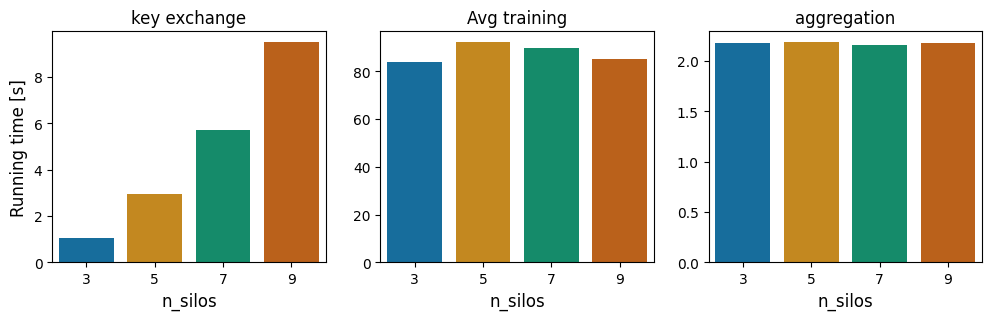

In [119]:
# For n_silos

n_silos_time_results = {"time": [], "kind": [], "n_silos": []}
n_silos_list = [3, 5, 7, 9]
key_exchnage_list = [1.0501000881195068, 2.9396181106567383, 5.725150108337402, 9.477273941040039]
# multiplicative_blind_user_hist_list = [4.100116968154907, 4.531608819961548, 4.887310028076172, 5.087700128555298]
training_silo_list = [[85.51134705543518, 94.669105052948, 71.39624691009521], [91.01992702484131, 94.6601710319519, 88.53735017776489, 94.27006006240845, 91.61543083190918], [83.21179986000061, 92.95768213272095, 87.23076605796814, 96.2587890625, 93.93128395080566, 84.52289700508118, 89.68692398071289], [94.12726998329163, 79.14221906661987, 86.59900283813477, 86.83643698692322, 78.3361611366272, 86.65233302116394, 85.84408116340637, 82.54178977012634, 86.9701840877533]]
aggregation_list = [2.1742188930511475, 2.1841750144958496, 2.1623528003692627, 2.177841901779175]

for i in range(len(n_silos_list)):
    n_silos_time_results['time'].append(key_exchnage_list[i])
    n_silos_time_results['kind'].append('key exchange')
    n_silos_time_results['n_silos'].append(n_silos_list[i])

    # n_silos_time_results['time'].append(multiplicative_blind_user_hist_list[i])
    # n_silos_time_results['kind'].append('multiplicative blind user hist')
    # n_silos_time_results['n_silos'].append(n_silos_list[i])

    n_silos_time_results['time'].append(sum(training_silo_list[i])/len(training_silo_list[i]))
    n_silos_time_results['kind'].append('Avg training')
    n_silos_time_results['n_silos'].append(n_silos_list[i])

    n_silos_time_results['time'].append(aggregation_list[i])
    n_silos_time_results['kind'].append('aggregation')
    n_silos_time_results['n_silos'].append(n_silos_list[i])


# kinds = ["key exchange", "multiplicative blind user hist", "Avg training", "aggregation"]
kinds = ["key exchange", "Avg training", "aggregation"]

fig, axes = plt.subplots(1, len(kinds), figsize=(len(kinds)*4, 3))
for j, kind in enumerate(kinds):
    times = [n_silos_time_results['time'][i] for i in range(len(n_silos_time_results['kind'])) if n_silos_time_results['kind'][i] == kind]
    n_silos = [n_silos_time_results['n_silos'][i] for i in range(len(n_silos_time_results['kind'])) if n_silos_time_results['kind'][i] == kind]

    sns.barplot(x=n_silos, y=times, palette="colorblind", ax=axes[j])
    axes[j].set_xlabel("n_silos", fontsize=12)
    if j == 0:
        axes[j].set_ylabel("Running time [s]", fontsize=12)
    axes[j].set_title(f"{kind}", fontsize=12)
fig.savefig(
    os.path.join(img_path, "private_weighting_artificial_runtime_for_n_silos.png"),
    dpi=150,
    bbox_inches="tight",
)
plt.show()

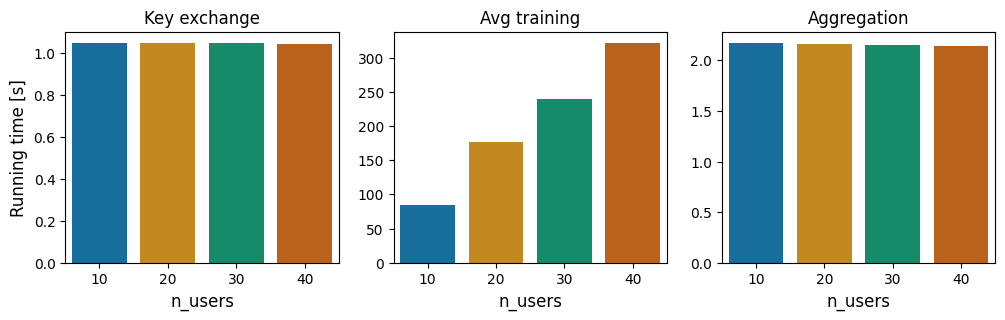

In [120]:
# For n_users

n_users_time_results = {"time": [], "kind": [], "n_users": []}
n_users_list = [10, 20, 30, 40]
key_exchnage_list = [1.0501000881195068, 1.0501000881195068, 1.0501000881195068, 1.0446362495422363]
training_silo_list = [[85.51134705543518, 94.669105052948, 71.39624691009521], [179.95025610923767, 179.33229804039001, 169.8616497516632], [220.05000114440918, 256.8751108646393, 241.8202509880066], [319.25748205184937, 309.42834091186523, 336.7686347961426]]
aggregation_list = [2.1742188930511475, 2.156702995300293, 2.148691177368164, 2.1438820362091064]


for i in range(len(n_users_list)):
    n_users_time_results['time'].append(key_exchnage_list[i])
    n_users_time_results['kind'].append('Key exchange')
    n_users_time_results['n_users'].append(n_users_list[i])

    n_users_time_results['time'].append(sum(training_silo_list[i])/len(training_silo_list[i]))
    n_users_time_results['kind'].append('Avg training')
    n_users_time_results['n_users'].append(n_users_list[i])

    n_users_time_results['time'].append(aggregation_list[i])
    n_users_time_results['kind'].append('Aggregation')
    n_users_time_results['n_users'].append(n_users_list[i])


kinds = ["Key exchange", "Avg training", "Aggregation"]

fig, axes = plt.subplots(1, len(kinds), figsize=(len(kinds)*4, 3))
for j, kind in enumerate(kinds):
    times = [n_users_time_results['time'][i] for i in range(len(n_users_time_results['kind'])) if n_users_time_results['kind'][i] == kind]
    n_users = [n_users_time_results['n_users'][i] for i in range(len(n_users_time_results['kind'])) if n_users_time_results['kind'][i] == kind]

    sns.barplot(x=n_users, y=times, palette="colorblind", ax=axes[j])
    axes[j].set_xlabel("n_users", fontsize=12)
    if j == 0:
        axes[j].set_ylabel("Running time [s]", fontsize=12)
    axes[j].set_title(f"{kind}", fontsize=12)
fig.savefig(
    os.path.join(img_path, "private_weighting_artificial_runtime_for_n_users.png"),
    dpi=150,
    bbox_inches="tight",
)
plt.show()

## Effect of user-level subsampling
- creditcard
- mnsit

In [28]:
user_level_subsampling_file_paths = get_result_files_of_script("user_level_subsampling")
img_file_prefix = "user_level_subsampling"

+++ dirname /Users/fumiyuki/research/AcSilo/acsilo/exp/script/user_level_subsampling.sh
++ cd /Users/fumiyuki/research/AcSilo/acsilo/exp/script
++ pwd -P
+ SCRIPT_PATH=/Users/fumiyuki/research/AcSilo/acsilo/exp/script
+ RUN_SIMULATION_PATH=/Users/fumiyuki/research/AcSilo/acsilo/exp/script/../../src/run_simulation.py
+ VERSION=0
+ TIMES=5
+ DRY_RUN=
+ for arg in '"$@"'
+ '[' --dry_run == --dry_run ']'
+ DRY_RUN=--dry_run
+ GPU=
+ python /Users/fumiyuki/research/AcSilo/acsilo/exp/script/../../src/run_simulation.py --dataset_name=creditcard --verbose=1 --agg_strategy=ULDP-AVG-w --n_users=1000 --global_learning_rate=10.0 --clipping_bound=1.0 --n_total_round=100 --local_learning_rate=0.01 --local_epochs=30 --sigma=5.0 --user_dist=zipf --user_alpha=0.5 --silo_dist=zipf --silo_alpha=2.0 --times=5 --version=0 --dry_run
+ sampling_rate_q_list=(0.1 0.3 0.5 0.7)
+ for sampling_rate_q in '"${sampling_rate_q_list[@]}"'
+ python /Users/fumiyuki/research/AcSilo/acsilo/exp/script/../../src/run_simulat

Namespace(seed=0, gpu_id=None, silo_id=None, dataset_name='creditcard', model_name='cnn', n_users=1000, n_silos=5, user_dist='zipf', silo_dist='zipf', user_alpha=0.5, silo_alpha=2.0, n_labels=1, typical_scenaio=None, n_silo_per_round=5, n_total_round=100, local_epochs=30, local_learning_rate=0.01, global_learning_rate=10.0, local_batch_size=64, weight_decay=0.001, client_optimizer='sgd', agg_strategy='ULDP-AVG-w', group_k=2, sigma=5.0, clipping_bound=1.0, delta=1e-05, sampling_rate_q=0.1, verbose=1, hyper_parameter_tuning=None, times=5, exp_dist=None, version=0, dry_run=False, secure_w=False)
Namespace(seed=0, gpu_id=None, silo_id=None, dataset_name='creditcard', model_name='cnn', n_users=1000, n_silos=5, user_dist='zipf', silo_dist='zipf', user_alpha=0.5, silo_alpha=2.0, n_labels=1, typical_scenaio=None, n_silo_per_round=5, n_total_round=100, local_epochs=30, local_learning_rate=0.01, global_learning_rate=10.0, local_batch_size=64, weight_decay=0.001, client_optimizer='sgd', agg_strat

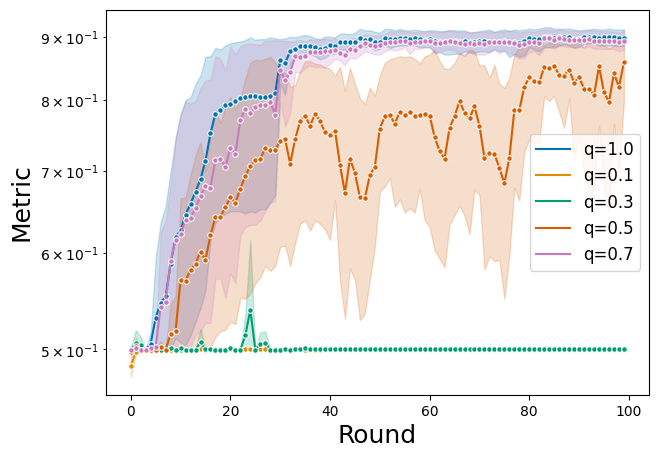

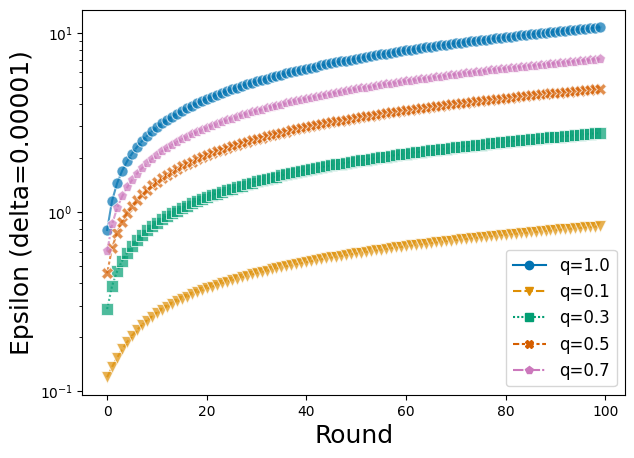

In [150]:
# creditcard

dataset_name = "creditcard"
setting_map = {0: "q=1.0", 1: "q=0.1", 2: "q=0.3", 3: "q=0.5", 4: "q=0.7"}

target_paths = []
for file_path in user_level_subsampling_file_paths:
    with open(file_path, "r") as json_file:
        results = json.load(json_file)
    args = results["args"]
    if f"dataset_name='{dataset_name}'" in args:
        target_paths.append(file_path)

# plot_multiple_losses(target_paths, setting_map, img_file=f"{img_file_prefix}_{dataset_name}")
plot_multiple_metrics(target_paths, setting_map, img_file=f"{img_file_prefix}_{dataset_name}")
plot_multiple_epsilons(target_paths, setting_map, img_file=f"{img_file_prefix}_{dataset_name}", n_rounds=100, modified=False)

Namespace(seed=0, gpu_id=None, silo_id=None, dataset_name='mnist', model_name='cnn', n_users=10000, n_silos=5, user_dist='zipf', silo_dist='zipf', user_alpha=0.5, silo_alpha=2.0, n_labels=1, typical_scenaio=None, n_silo_per_round=5, n_total_round=200, local_epochs=50, local_learning_rate=0.01, global_learning_rate=100.0, local_batch_size=64, weight_decay=0.001, client_optimizer='sgd', agg_strategy='ULDP-AVG-w', group_k=2, sigma=5.0, clipping_bound=0.1, delta=1e-05, sampling_rate_q=0.1, verbose=1, hyper_parameter_tuning=None, times=5, exp_dist=None, version=0, dry_run=True, secure_w=False)
Namespace(seed=0, gpu_id=0, silo_id=None, dataset_name='mnist', model_name='cnn', n_users=10000, n_silos=5, user_dist='zipf', silo_dist='zipf', user_alpha=0.5, silo_alpha=2.0, n_labels=1, typical_scenaio=None, n_silo_per_round=5, n_total_round=200, local_epochs=50, local_learning_rate=0.01, global_learning_rate=100.0, local_batch_size=64, weight_decay=0.001, client_optimizer='sgd', agg_strategy='ULDP-

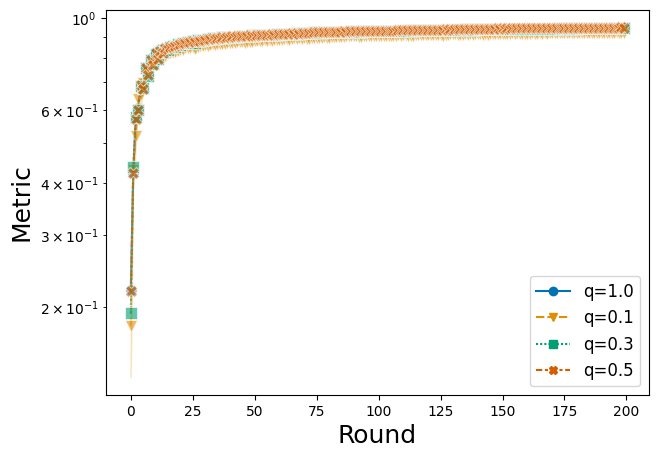

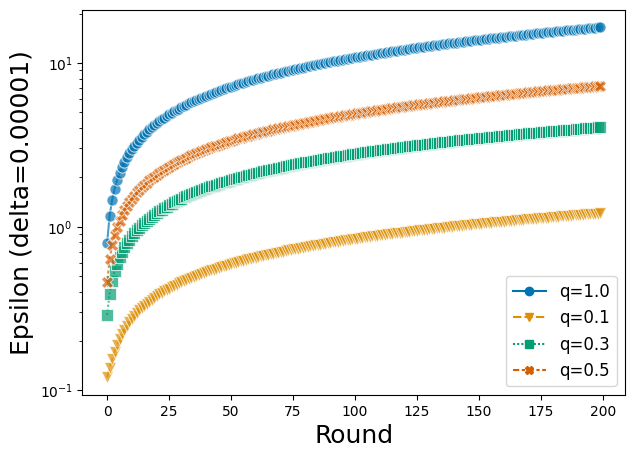

In [37]:
# mnist

dataset_name = "mnist"
setting_map = {0: "q=1.0", 1: "q=0.1", 2: "q=0.3", 3: "q=0.5"}

target_paths = []
for file_path in user_level_subsampling_file_paths:
    with open(file_path, "r") as json_file:
        results = json.load(json_file)
    args = results["args"]
    if f"dataset_name='{dataset_name}'" in args:
        target_paths.append(file_path)

# plot_multiple_losses(target_paths, setting_map, img_file=f"user_level_subsampling_{dataset_name}")
plot_multiple_metrics(target_paths, setting_map, img_file=f"user_level_subsampling_{dataset_name}")
plot_multiple_epsilons(target_paths, setting_map, img_file=f"user_level_subsampling_{dataset_name}", n_rounds=100)

## Effect of optimal weighting
- creditcard
- tcga_brca

In [46]:
optimal_weighting_file_paths = get_result_files_of_script("optimal_weighting")
img_file_prefix = "optimal_weighting"

Namespace(seed=0, gpu_id=None, silo_id=None, dataset_name='creditcard', model_name='cnn', n_users=1000, n_silos=5, user_dist='uniform', silo_dist='uniform', user_alpha=0.5, silo_alpha=2.0, n_labels=1, typical_scenaio=None, n_silo_per_round=5, n_total_round=100, local_epochs=30, local_learning_rate=0.01, global_learning_rate=10.0, local_batch_size=64, weight_decay=0.001, client_optimizer='sgd', agg_strategy='ULDP-AVG', group_k=2, sigma=5.0, clipping_bound=0.1, delta=1e-05, sampling_rate_q=0.1, verbose=1, hyper_parameter_tuning=None, times=5, exp_dist=None, version=0, dry_run=False, secure_w=False)
Namespace(seed=0, gpu_id=None, silo_id=None, dataset_name='creditcard', model_name='cnn', n_users=1000, n_silos=5, user_dist='uniform', silo_dist='uniform', user_alpha=0.5, silo_alpha=2.0, n_labels=1, typical_scenaio=None, n_silo_per_round=5, n_total_round=100, local_epochs=30, local_learning_rate=0.01, global_learning_rate=10.0, local_batch_size=64, weight_decay=0.001, client_optimizer='sgd',

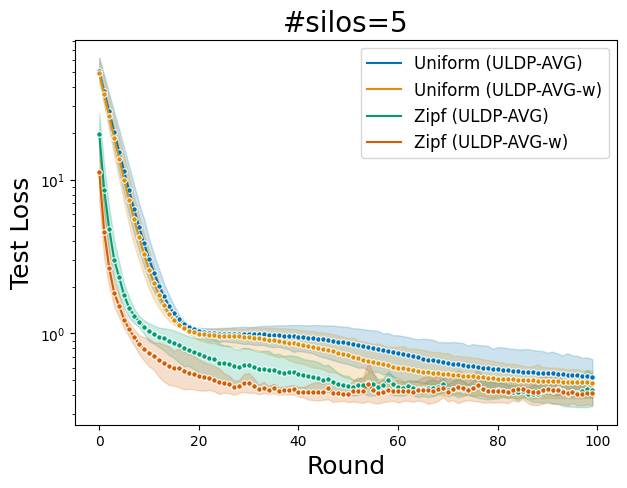

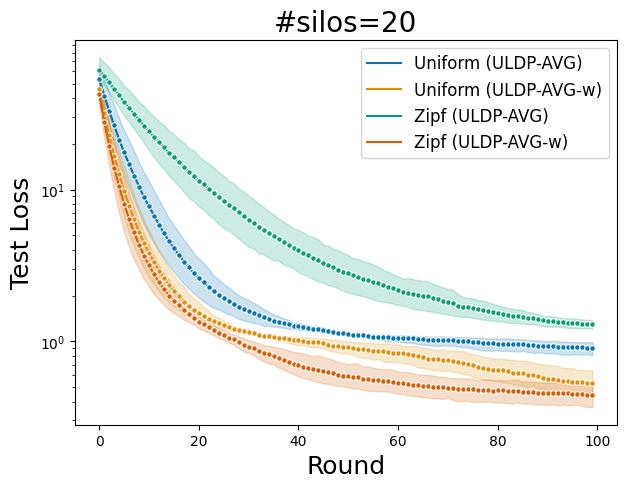

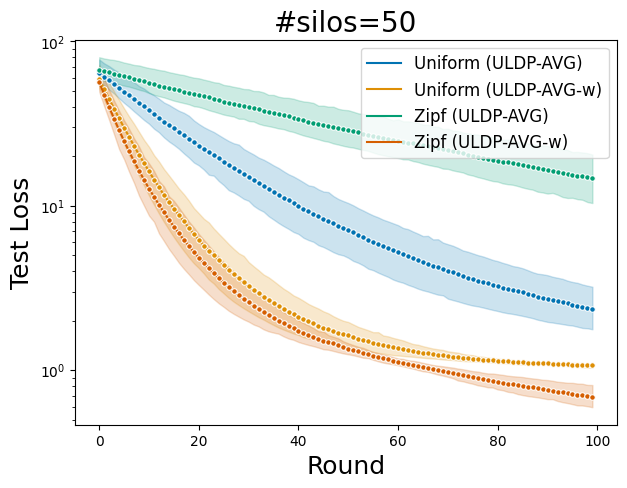

In [47]:
# creditcard

dataset_name = "creditcard"
n_silos_list = [5, 20, 50]
setting_map = {0: "Uniform (ULDP-AVG)", 1: "Uniform (ULDP-AVG-w)", 2: "Zipf (ULDP-AVG)", 3: "Zipf (ULDP-AVG-w)"}

for n_silos in n_silos_list:
    target_paths = []
    for file_path in optimal_weighting_file_paths:
        with open(file_path, "r") as json_file:
            results = json.load(json_file)
        args = results["args"]
        if f"dataset_name='{dataset_name}'" in args and f"n_silos={n_silos}," in args:
            target_paths.append(file_path)

    plot_multiple_losses(target_paths, setting_map, title=f"#silos={n_silos}", img_file=f"{img_file_prefix}_{n_silos}_{dataset_name}")
    # plot_multiple_metrics(target_paths, setting_map, title=f"#silos={n_silos}", img_file=f"{img_file_prefix}_{n_silos}_{dataset_name}")

Namespace(seed=0, gpu_id=None, silo_id=None, dataset_name='tcga_brca', model_name='cnn', n_users=200, n_silos=6, user_dist='uniform', silo_dist='uniform', user_alpha=0.5, silo_alpha=2.0, n_labels=1, typical_scenaio=None, n_silo_per_round=6, n_total_round=50, local_epochs=50, local_learning_rate=0.001, global_learning_rate=10.0, local_batch_size=8, weight_decay=0.001, client_optimizer='sgd', agg_strategy='ULDP-AVG', group_k=2, sigma=5.0, clipping_bound=0.1, delta=1e-05, sampling_rate_q=0.1, verbose=1, hyper_parameter_tuning=None, times=5, exp_dist=None, version=0, dry_run=False, secure_w=False)
Namespace(seed=0, gpu_id=None, silo_id=None, dataset_name='tcga_brca', model_name='cnn', n_users=200, n_silos=6, user_dist='uniform', silo_dist='uniform', user_alpha=0.5, silo_alpha=2.0, n_labels=1, typical_scenaio=None, n_silo_per_round=6, n_total_round=50, local_epochs=50, local_learning_rate=0.001, global_learning_rate=10.0, local_batch_size=8, weight_decay=0.001, client_optimizer='sgd', agg_s

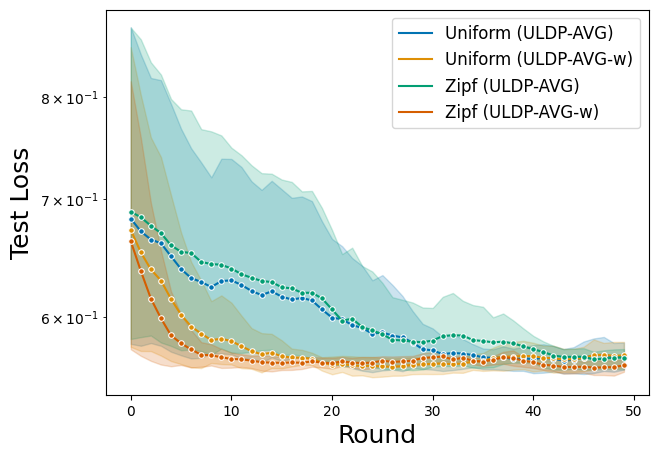

In [48]:
# tcga_brca

dataset_name = "tcga_brca"
setting_map = {0: "Uniform (ULDP-AVG)", 1: "Uniform (ULDP-AVG-w)", 2: "Zipf (ULDP-AVG)", 3: "Zipf (ULDP-AVG-w)"}

target_paths = []
for file_path in optimal_weighting_file_paths:
    with open(file_path, "r") as json_file:
        results = json.load(json_file)
    args = results["args"]
    if f"dataset_name='{dataset_name}'" in args:
        target_paths.append(file_path)

plot_multiple_losses(target_paths, setting_map, img_file=f"{img_file_prefix}_{dataset_name}")
# plot_multiple_metrics(target_paths, setting_map, img_file=f"{img_file_prefix}_{dataset_name}")
# plot_multiple_epsilons(target_paths, setting_map, img_file=f"{img_file_prefix}_{dataset_name}")

## Privacy-utility
- mnist
- creditcard
- tcga_brca
- heart_disease

In [38]:
privacy_utility_file_paths = get_result_files_of_script("privacy_utility")
img_file_prefix = "privacy_utility"

+++ dirname /Users/fumiyuki/research/AcSilo/acsilo/exp/script/privacy_utility.sh
++ cd /Users/fumiyuki/research/AcSilo/acsilo/exp/script
++ pwd -P
+ SCRIPT_PATH=/Users/fumiyuki/research/AcSilo/acsilo/exp/script
+ RUN_SIMULATION_PATH=/Users/fumiyuki/research/AcSilo/acsilo/exp/script/../../src/run_simulation.py
+ VERSION=0
+ TIMES=5
+ DRY_RUN=
+ for arg in '"$@"'
+ '[' --dry_run == --dry_run ']'
+ DRY_RUN=--dry_run
+ GPU=
+ counter=0
+ RESTART=0
+ trap 'echo "Error occurred at counter=$counter"; exit 1' ERR
+ n_users_list=(100 1000)
+ silo_dist_list=("uniform" "zipf")
+ user_dist_list=("uniform" "zipf-iid")
+ dist_length=2
+ for n_users in '"${n_users_list[@]}"'
+ (( i=0 ))
+ (( i<2 ))
+ user_dist=uniform
+ silo_dist=uniform
+ (( counter >= RESTART ))
+ python /Users/fumiyuki/research/AcSilo/acsilo/exp/script/../../src/run_simulation.py --dataset_name=creditcard --verbose=1 --agg_strategy=DEFAULT --n_users=100 --global_learning_rate=1.0 --n_total_round=100 --local_learning_rate=0.01 --lo

Namespace(seed=0, gpu_id=None, silo_id=None, dataset_name='heart_disease', model_name='cnn', n_users=50, n_silos=4, user_dist='uniform', silo_dist='uniform', user_alpha=0.5, silo_alpha=2.0, n_labels=1, typical_scenaio=None, n_silo_per_round=4, n_total_round=50, local_epochs=50, local_learning_rate=0.001, global_learning_rate=1.0, local_batch_size=4, weight_decay=0.001, client_optimizer='sgd', agg_strategy='DEFAULT', group_k=2, sigma=5.0, clipping_bound=1.0, delta=1e-05, sampling_rate_q=0.1, verbose=1, hyper_parameter_tuning=None, times=5, exp_dist=None, version=0, dry_run=False, secure_w=False)
Namespace(seed=0, gpu_id=None, silo_id=None, dataset_name='heart_disease', model_name='cnn', n_users=50, n_silos=4, user_dist='uniform', silo_dist='uniform', user_alpha=0.5, silo_alpha=2.0, n_labels=1, typical_scenaio=None, n_silo_per_round=4, n_total_round=50, local_epochs=50, local_learning_rate=0.001, global_learning_rate=1.0, local_batch_size=4, weight_decay=0.001, client_optimizer='sgd', ag

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/opacus/accountants/analysis/rdp.py:74: RuntimeWarning: invalid value encountered in scalar subtract
  return math.log1p(math.exp(a - b)) + b  # log1p(x) = log(x + 1)


The group size must be a power of 2, but got group size = 39, use group size = 32
The group size must be a power of 2, but got group size = 39, use group size = 32
The group size must be a power of 2, but got group size = 39, use group size = 32
The group size must be a power of 2, but got group size = 39, use group size = 32
The group size must be a power of 2, but got group size = 39, use group size = 32
The group size must be a power of 2, but got group size = 39, use group size = 32
The group size must be a power of 2, but got group size = 39, use group size = 32
The group size must be a power of 2, but got group size = 39, use group size = 32
The group size must be a power of 2, but got group size = 39, use group size = 32
The group size must be a power of 2, but got group size = 39, use group size = 32
The group size must be a power of 2, but got group size = 39, use group size = 32
The group size must be a power of 2, but got group size = 39, use group size = 32
The group size m

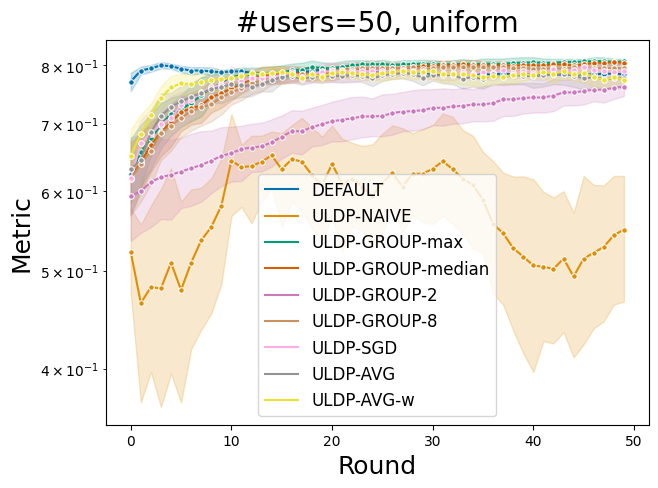

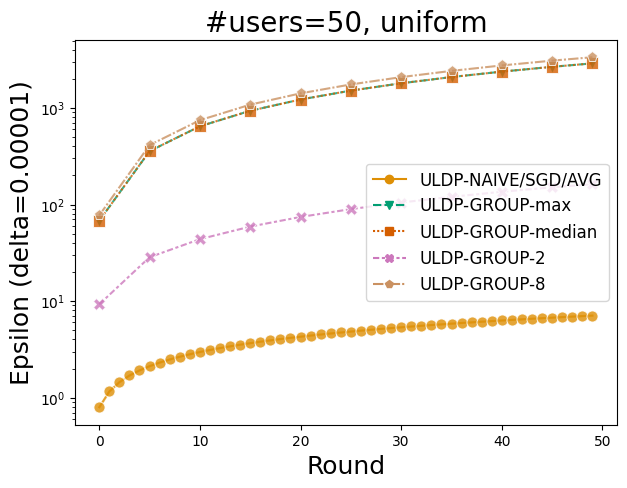

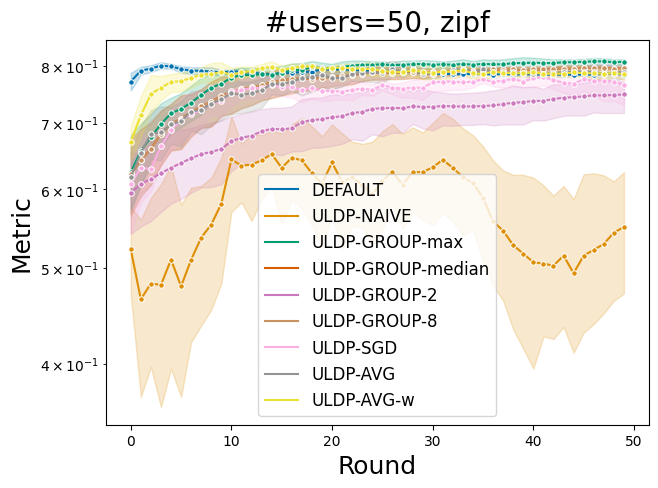

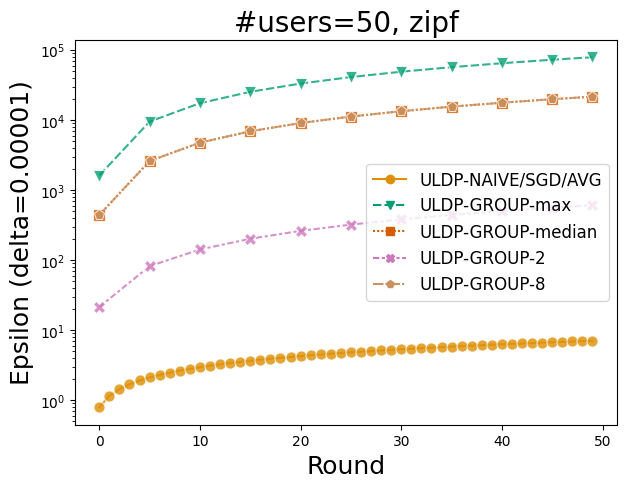

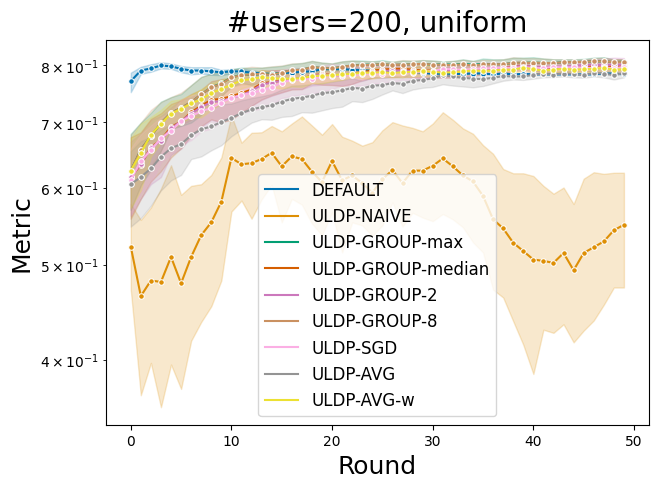

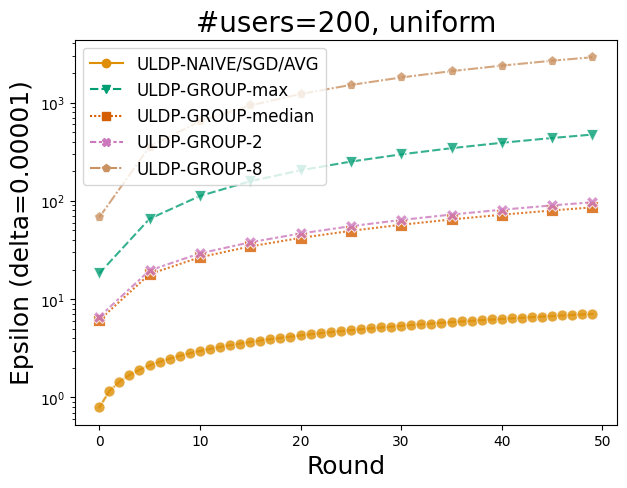

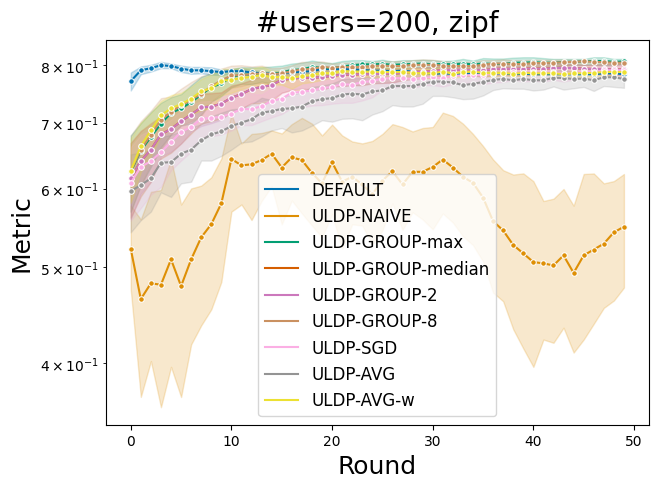

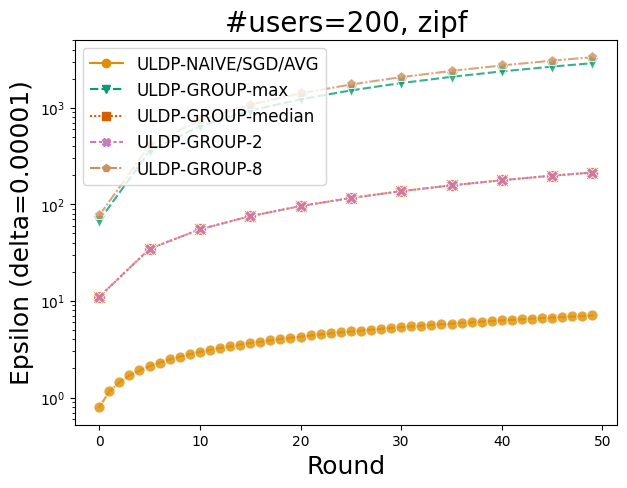

In [109]:
# heart_disease

n_users_list = [50, 200]
dist_list = ["uniform", "zipf"]
dataset_name = "heart_disease"
setting_map = {0: "DEFAULT", 1: "ULDP-NAIVE", 2: "ULDP-GROUP-max", 3: "ULDP-GROUP-median", 4: "ULDP-GROUP-2", 5: "ULDP-GROUP-8", 6: "ULDP-SGD", 7: "ULDP-AVG", 8: "ULDP-AVG-w"}
privacy_setting_map = {0: "DEFAULT", 1: "ULDP-NAIVE/SGD/AVG", 2: "ULDP-GROUP-max", 3: "ULDP-GROUP-median", 4: "ULDP-GROUP-2", 5: "ULDP-GROUP-8", 6: "ULDP-NAIVE/SGD/AVG", 7: "ULDP-NAIVE/SGD/AVG", 8: "ULDP-NAIVE/SGD/AVG"}
for n_users in n_users_list:
    for silo_dist in dist_list:
        target_file_paths = []
        for file_path in privacy_utility_file_paths:
            with open(file_path, "r") as json_file:
                results = json.load(json_file)
            args = results["args"]
            if f"dataset_name='{dataset_name}'" in args and f"n_users={n_users}," in args and f"silo_dist='{silo_dist}'" in args:
                target_file_paths.append(file_path)

        # plot_multiple_losses(target_file_paths, setting_map, title=f"#users={n_users}, {silo_dist}", img_file=f"{img_file_prefix}_{dataset_name}_{n_users}_{silo_dist}")
        plot_multiple_metrics(target_file_paths, setting_map, title=f"#users={n_users}, {silo_dist}", img_file=f"{img_file_prefix}_{dataset_name}_{n_users}_{silo_dist}")
        plot_multiple_epsilons(target_file_paths, privacy_setting_map, title=f"#users={n_users}, {silo_dist}", img_file=f"{img_file_prefix}_{dataset_name}_{n_users}_{silo_dist}", n_rounds=50)

Namespace(seed=0, gpu_id=None, silo_id=None, dataset_name='tcga_brca', model_name='cnn', n_users=50, n_silos=6, user_dist='uniform', silo_dist='uniform', user_alpha=0.5, silo_alpha=2.0, n_labels=1, typical_scenaio=None, n_silo_per_round=6, n_total_round=50, local_epochs=50, local_learning_rate=0.001, global_learning_rate=1.0, local_batch_size=8, weight_decay=0.001, client_optimizer='sgd', agg_strategy='DEFAULT', group_k=2, sigma=5.0, clipping_bound=1.0, delta=1e-05, sampling_rate_q=0.1, verbose=1, hyper_parameter_tuning=None, times=5, exp_dist=None, version=0, dry_run=False, secure_w=False)
Namespace(seed=0, gpu_id=None, silo_id=None, dataset_name='tcga_brca', model_name='cnn', n_users=50, n_silos=6, user_dist='uniform', silo_dist='uniform', user_alpha=0.5, silo_alpha=2.0, n_labels=1, typical_scenaio=None, n_silo_per_round=6, n_total_round=50, local_epochs=50, local_learning_rate=0.001, global_learning_rate=1.0, local_batch_size=8, weight_decay=0.001, client_optimizer='sgd', agg_strate

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/opacus/accountants/analysis/rdp.py:74: RuntimeWarning: invalid value encountered in scalar subtract
  return math.log1p(math.exp(a - b)) + b  # log1p(x) = log(x + 1)


The group size must be a power of 2, but got group size = 71, use group size = 64
The group size must be a power of 2, but got group size = 71, use group size = 64
The group size must be a power of 2, but got group size = 71, use group size = 64
The group size must be a power of 2, but got group size = 71, use group size = 64
The group size must be a power of 2, but got group size = 71, use group size = 64
The group size must be a power of 2, but got group size = 71, use group size = 64
The group size must be a power of 2, but got group size = 71, use group size = 64
The group size must be a power of 2, but got group size = 71, use group size = 64
The group size must be a power of 2, but got group size = 71, use group size = 64
The group size must be a power of 2, but got group size = 71, use group size = 64
The group size must be a power of 2, but got group size = 71, use group size = 64
The group size must be a power of 2, but got group size = 71, use group size = 64
The group size m

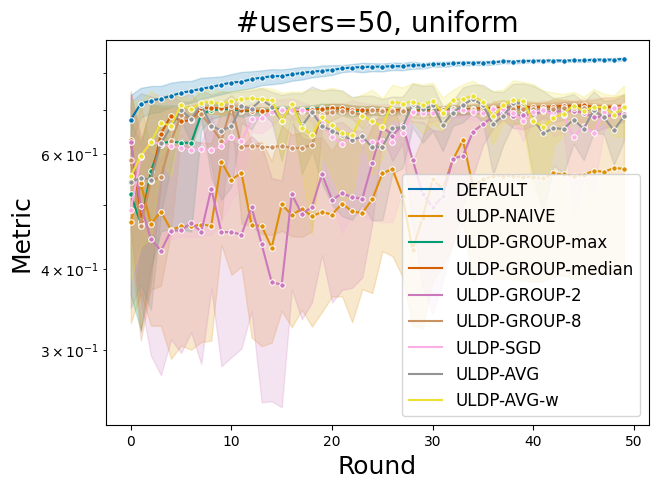

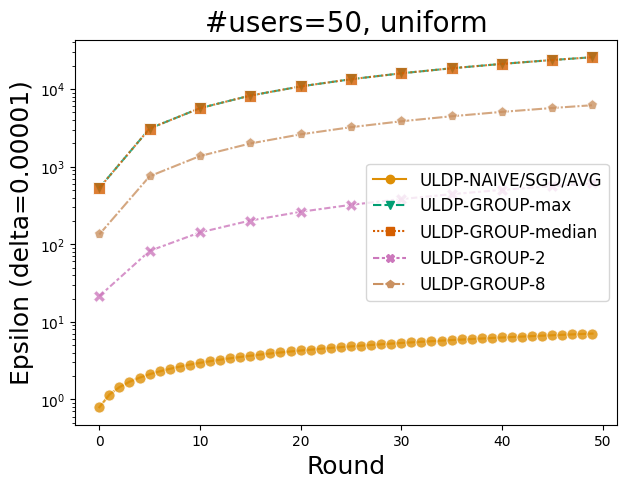

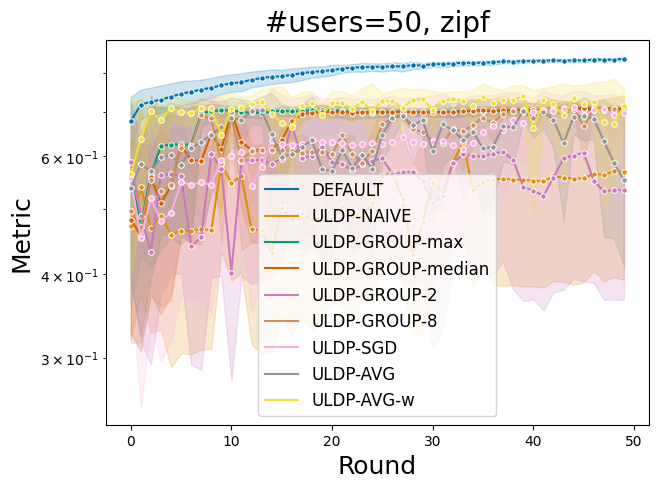

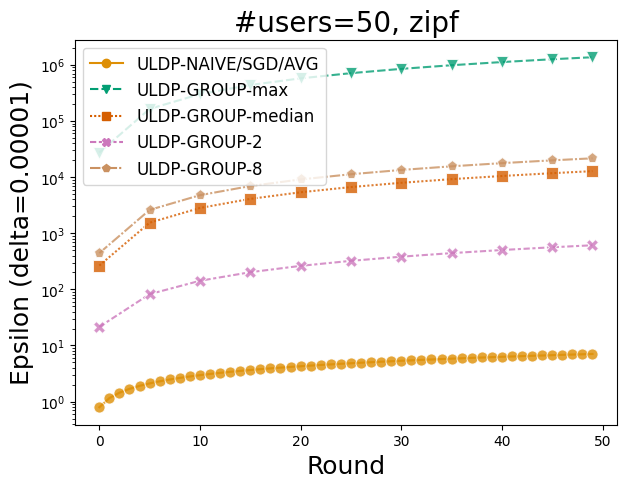

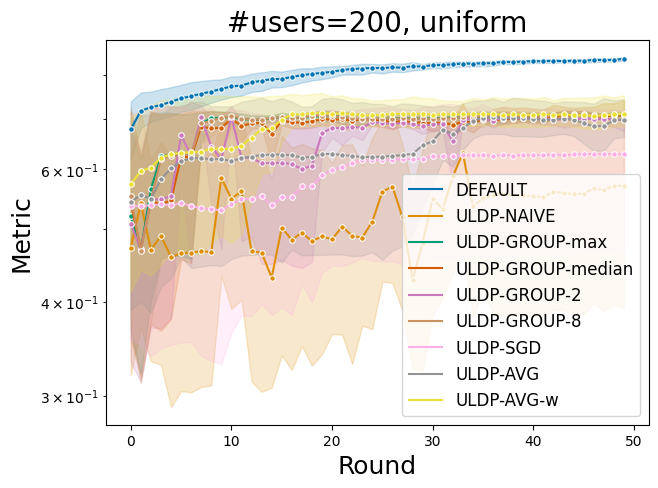

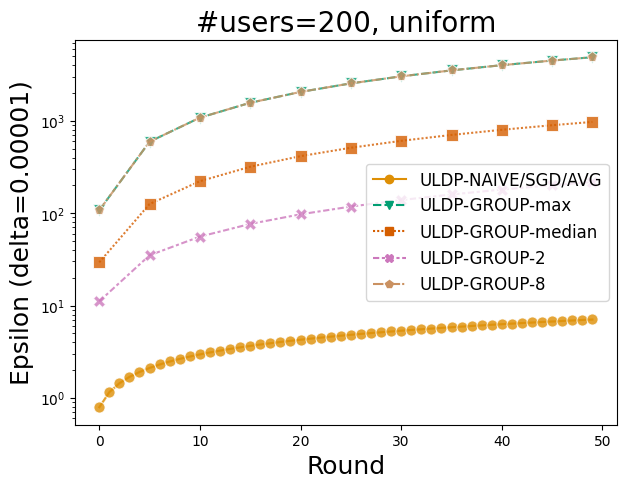

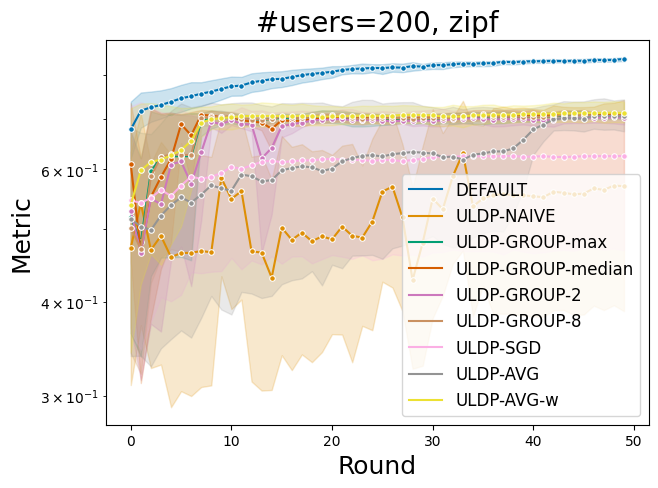

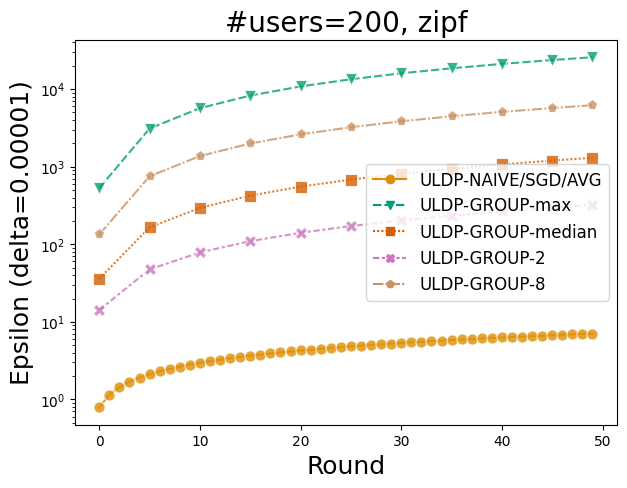

In [110]:
# tcga_brca

n_users_list = [50, 200]
dist_list = ["uniform", "zipf"]
dataset_name = "tcga_brca"
setting_map = {0: "DEFAULT", 1: "ULDP-NAIVE", 2: "ULDP-GROUP-max", 3: "ULDP-GROUP-median", 4: "ULDP-GROUP-2", 5: "ULDP-GROUP-8", 6: "ULDP-SGD", 7: "ULDP-AVG", 8: "ULDP-AVG-w"}
privacy_setting_map = {0: "DEFAULT", 1: "ULDP-NAIVE/SGD/AVG", 2: "ULDP-GROUP-max", 3: "ULDP-GROUP-median", 4: "ULDP-GROUP-2", 5: "ULDP-GROUP-8", 6: "ULDP-NAIVE/SGD/AVG", 7: "ULDP-NAIVE/SGD/AVG", 8: "ULDP-NAIVE/SGD/AVG"}
for n_users in n_users_list:
    for silo_dist in dist_list:
        target_file_paths = []
        for file_path in privacy_utility_file_paths:
            with open(file_path, "r") as json_file:
                results = json.load(json_file)
            args = results["args"]
            if f"dataset_name='{dataset_name}'" in args and f"n_users={n_users}," in args and f"silo_dist='{silo_dist}'" in args:
                target_file_paths.append(file_path)

        # plot_multiple_losses(target_file_paths, setting_map, title=f"#users={n_users}, {silo_dist}", img_file=f"{img_file_prefix}_{dataset_name}_{n_users}_{silo_dist}")
        plot_multiple_metrics(target_file_paths, setting_map, title=f"#users={n_users}, {silo_dist}", img_file=f"{img_file_prefix}_{dataset_name}_{n_users}_{silo_dist}")
        plot_multiple_epsilons(target_file_paths, privacy_setting_map, title=f"#users={n_users}, {silo_dist}", img_file=f"{img_file_prefix}_{dataset_name}_{n_users}_{silo_dist}", n_rounds=50)

Namespace(seed=0, gpu_id=None, silo_id=None, dataset_name='creditcard', model_name='cnn', n_users=100, n_silos=5, user_dist='uniform', silo_dist='uniform', user_alpha=0.5, silo_alpha=2.0, n_labels=1, typical_scenaio=None, n_silo_per_round=5, n_total_round=100, local_epochs=50, local_learning_rate=0.01, global_learning_rate=1.0, local_batch_size=64, weight_decay=0.001, client_optimizer='sgd', agg_strategy='DEFAULT', group_k=2, sigma=5.0, clipping_bound=1.0, delta=1e-05, sampling_rate_q=0.1, verbose=1, hyper_parameter_tuning=None, times=5, exp_dist=None, version=0, dry_run=False, secure_w=False)
Namespace(seed=0, gpu_id=None, silo_id=None, dataset_name='creditcard', model_name='cnn', n_users=100, n_silos=5, user_dist='uniform', silo_dist='uniform', user_alpha=0.5, silo_alpha=2.0, n_labels=1, typical_scenaio=None, n_silo_per_round=5, n_total_round=100, local_epochs=50, local_learning_rate=0.01, global_learning_rate=1.0, local_batch_size=64, weight_decay=0.001, client_optimizer='sgd', agg_

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/opacus/accountants/analysis/rdp.py:74: RuntimeWarning: invalid value encountered in scalar subtract
  return math.log1p(math.exp(a - b)) + b  # log1p(x) = log(x + 1)


The group size must be a power of 2, but got group size = 1200, use group size = 1024
The group size must be a power of 2, but got group size = 1200, use group size = 1024
The group size must be a power of 2, but got group size = 1200, use group size = 1024
The group size must be a power of 2, but got group size = 1200, use group size = 1024
The group size must be a power of 2, but got group size = 1200, use group size = 1024
The group size must be a power of 2, but got group size = 1200, use group size = 1024
The group size must be a power of 2, but got group size = 1200, use group size = 1024
The group size must be a power of 2, but got group size = 1200, use group size = 1024
The group size must be a power of 2, but got group size = 1200, use group size = 1024
The group size must be a power of 2, but got group size = 1200, use group size = 1024
The group size must be a power of 2, but got group size = 1200, use group size = 1024
The group size must be a power of 2, but got group siz

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/opacus/accountants/analysis/rdp.py:74: RuntimeWarning: invalid value encountered in scalar subtract
  return math.log1p(math.exp(a - b)) + b  # log1p(x) = log(x + 1)


The group size must be a power of 2, but got group size = 353, use group size = 256
The group size must be a power of 2, but got group size = 353, use group size = 256
The group size must be a power of 2, but got group size = 353, use group size = 256
The group size must be a power of 2, but got group size = 353, use group size = 256
The group size must be a power of 2, but got group size = 353, use group size = 256
The group size must be a power of 2, but got group size = 353, use group size = 256
The group size must be a power of 2, but got group size = 353, use group size = 256
The group size must be a power of 2, but got group size = 353, use group size = 256
The group size must be a power of 2, but got group size = 353, use group size = 256
The group size must be a power of 2, but got group size = 353, use group size = 256
The group size must be a power of 2, but got group size = 353, use group size = 256
The group size must be a power of 2, but got group size = 353, use group siz

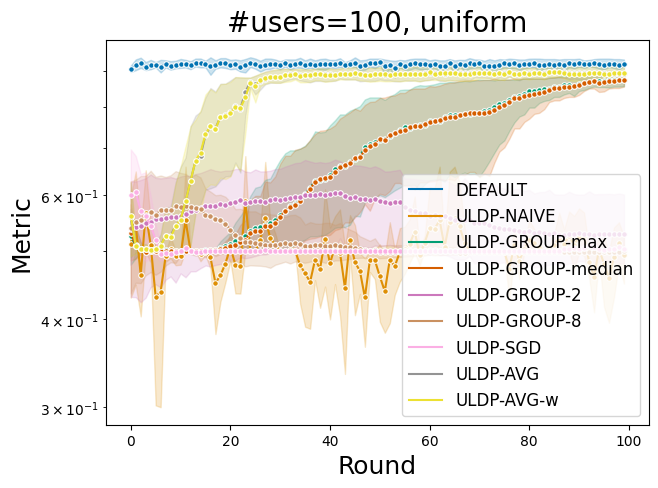

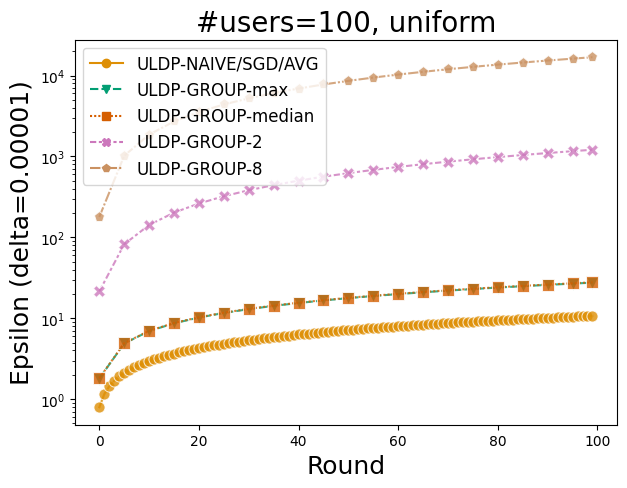

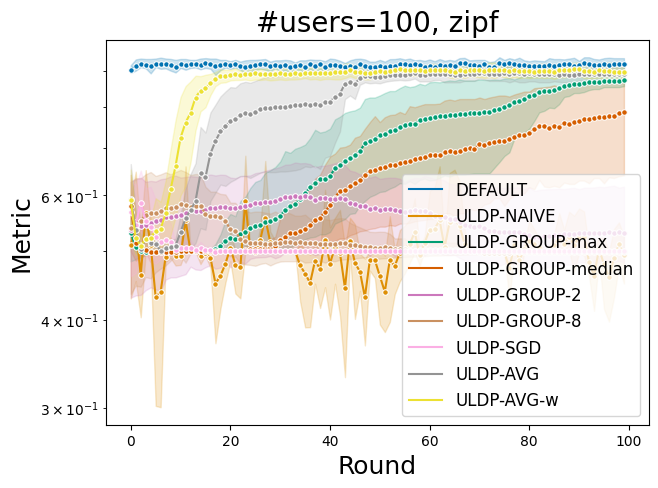

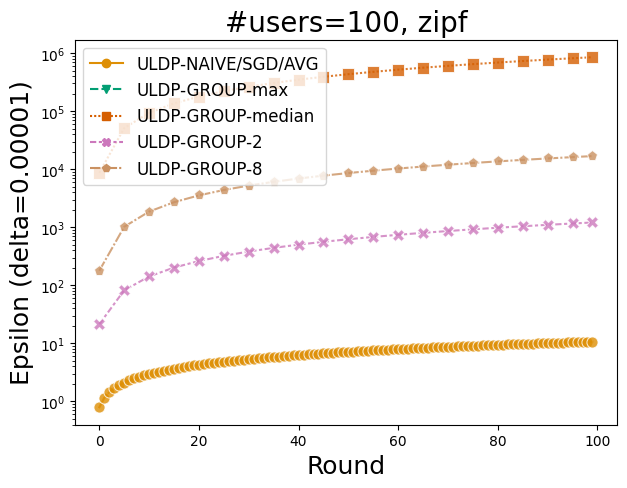

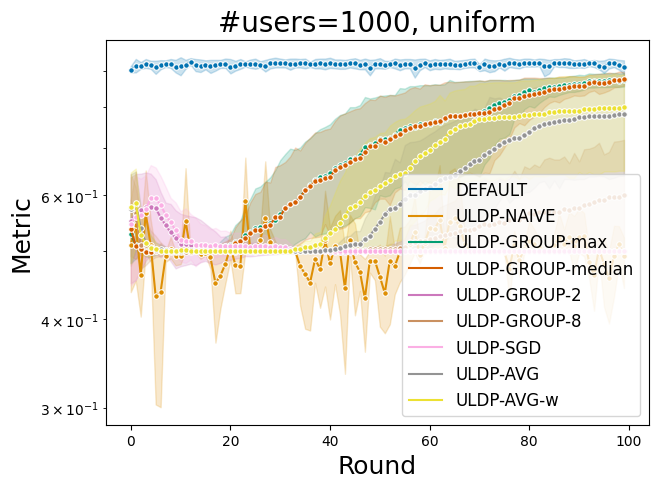

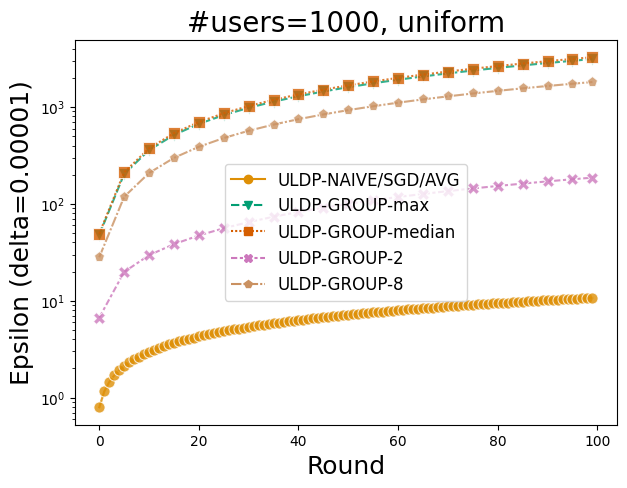

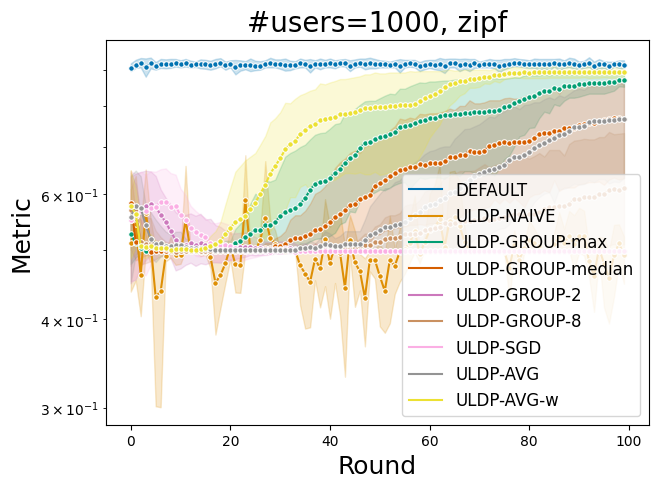

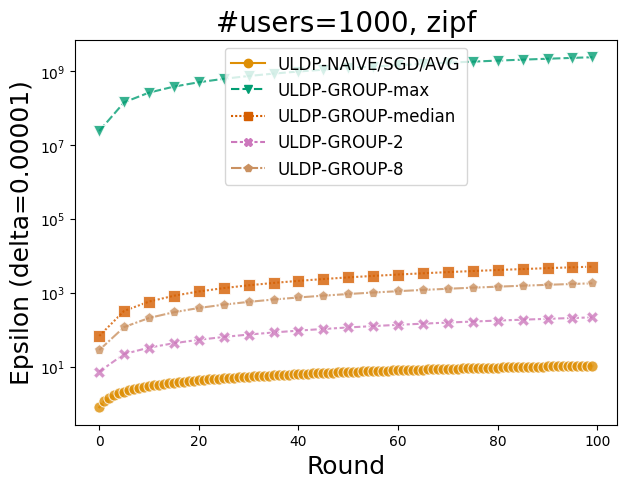

In [111]:
# creditcard

n_users_list = [100, 1000]
dist_list = ["uniform", "zipf"]
dataset_name = "creditcard"
setting_map = {0: "DEFAULT", 1: "ULDP-NAIVE", 2: "ULDP-GROUP-max", 3: "ULDP-GROUP-median", 4: "ULDP-GROUP-2", 5: "ULDP-GROUP-8", 6: "ULDP-SGD", 7: "ULDP-AVG", 8: "ULDP-AVG-w"}
privacy_setting_map = {0: "DEFAULT", 1: "ULDP-NAIVE/SGD/AVG", 2: "ULDP-GROUP-max", 3: "ULDP-GROUP-median", 4: "ULDP-GROUP-2", 5: "ULDP-GROUP-8", 6: "ULDP-NAIVE/SGD/AVG", 7: "ULDP-NAIVE/SGD/AVG", 8: "ULDP-NAIVE/SGD/AVG"}
for n_users in n_users_list:
    for silo_dist in dist_list:
        target_file_paths = []
        for file_path in privacy_utility_file_paths:
            with open(file_path, "r") as json_file:
                results = json.load(json_file)
            args = results["args"]
            if f"dataset_name='{dataset_name}'" in args and f"n_users={n_users}," in args and f"silo_dist='{silo_dist}'" in args:
                target_file_paths.append(file_path)

        # plot_multiple_losses(target_file_paths, setting_map, title=f"#users={n_users}, {silo_dist}", img_file=f"{img_file_prefix}_{dataset_name}_{n_users}_{silo_dist}")
        plot_multiple_metrics(target_file_paths, setting_map, title=f"#users={n_users}, {silo_dist}", img_file=f"{img_file_prefix}_{dataset_name}_{n_users}_{silo_dist}")
        plot_multiple_epsilons(target_file_paths, privacy_setting_map, title=f"#users={n_users}, {silo_dist}", img_file=f"{img_file_prefix}_{dataset_name}_{n_users}_{silo_dist}", n_rounds=100)

Namespace(seed=0, gpu_id=3, silo_id=None, dataset_name='mnist', model_name='cnn', n_users=100, n_silos=5, user_dist='uniform', silo_dist='uniform', user_alpha=0.5, silo_alpha=2.0, n_labels=2, typical_scenaio=None, n_silo_per_round=5, n_total_round=100, local_epochs=50, local_learning_rate=0.01, global_learning_rate=1.0, local_batch_size=64, weight_decay=0.001, client_optimizer='sgd', agg_strategy='DEFAULT', group_k=2, sigma=5.0, clipping_bound=1.0, delta=1e-05, sampling_rate_q=0.1, verbose=1, hyper_parameter_tuning=None, times=1, exp_dist=None, version=0, dry_run=False, secure_w=False)
Namespace(seed=0, gpu_id=None, silo_id=None, dataset_name='mnist', model_name='cnn', n_users=100, n_silos=5, user_dist='uniform', silo_dist='uniform', user_alpha=0.5, silo_alpha=2.0, n_labels=2, typical_scenaio=None, n_silo_per_round=5, n_total_round=100, local_epochs=50, local_learning_rate=0.01, global_learning_rate=1.0, local_batch_size=64, weight_decay=0.001, client_optimizer='sgd', agg_strategy='ULD

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/opacus/accountants/analysis/rdp.py:74: RuntimeWarning: invalid value encountered in scalar subtract
  return math.log1p(math.exp(a - b)) + b  # log1p(x) = log(x + 1)


The group size must be a power of 2, but got group size = 561, use group size = 512
The group size must be a power of 2, but got group size = 561, use group size = 512
The group size must be a power of 2, but got group size = 561, use group size = 512
The group size must be a power of 2, but got group size = 561, use group size = 512
The group size must be a power of 2, but got group size = 561, use group size = 512
The group size must be a power of 2, but got group size = 561, use group size = 512
The group size must be a power of 2, but got group size = 561, use group size = 512
The group size must be a power of 2, but got group size = 561, use group size = 512
The group size must be a power of 2, but got group size = 561, use group size = 512
The group size must be a power of 2, but got group size = 561, use group size = 512
The group size must be a power of 2, but got group size = 561, use group size = 512
The group size must be a power of 2, but got group size = 561, use group siz

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/opacus/accountants/analysis/rdp.py:74: RuntimeWarning: invalid value encountered in scalar subtract
  return math.log1p(math.exp(a - b)) + b  # log1p(x) = log(x + 1)


The group size must be a power of 2, but got group size = 2989, use group size = 2048
The group size must be a power of 2, but got group size = 2989, use group size = 2048
The group size must be a power of 2, but got group size = 2989, use group size = 2048
The group size must be a power of 2, but got group size = 2989, use group size = 2048
The group size must be a power of 2, but got group size = 2989, use group size = 2048
The group size must be a power of 2, but got group size = 2989, use group size = 2048
The group size must be a power of 2, but got group size = 2989, use group size = 2048
The group size must be a power of 2, but got group size = 2989, use group size = 2048
The group size must be a power of 2, but got group size = 2989, use group size = 2048
The group size must be a power of 2, but got group size = 2989, use group size = 2048
The group size must be a power of 2, but got group size = 2989, use group size = 2048
The group size must be a power of 2, but got group siz

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/opacus/accountants/analysis/rdp.py:74: RuntimeWarning: invalid value encountered in scalar subtract
  return math.log1p(math.exp(a - b)) + b  # log1p(x) = log(x + 1)


The group size must be a power of 2, but got group size = 3265, use group size = 2048
The group size must be a power of 2, but got group size = 3265, use group size = 2048
The group size must be a power of 2, but got group size = 3265, use group size = 2048
The group size must be a power of 2, but got group size = 3265, use group size = 2048
The group size must be a power of 2, but got group size = 3265, use group size = 2048
The group size must be a power of 2, but got group size = 3265, use group size = 2048
The group size must be a power of 2, but got group size = 3265, use group size = 2048
The group size must be a power of 2, but got group size = 3265, use group size = 2048
The group size must be a power of 2, but got group size = 3265, use group size = 2048
The group size must be a power of 2, but got group size = 3265, use group size = 2048
The group size must be a power of 2, but got group size = 3265, use group size = 2048
The group size must be a power of 2, but got group siz

/Users/fumiyuki/.pyenv/versions/3.9.2/envs/acsilo/lib/python3.9/site-packages/opacus/accountants/analysis/rdp.py:74: RuntimeWarning: invalid value encountered in scalar subtract
  return math.log1p(math.exp(a - b)) + b  # log1p(x) = log(x + 1)


The group size must be a power of 2, but got group size = 355, use group size = 256
The group size must be a power of 2, but got group size = 355, use group size = 256
The group size must be a power of 2, but got group size = 355, use group size = 256
The group size must be a power of 2, but got group size = 355, use group size = 256
The group size must be a power of 2, but got group size = 355, use group size = 256
The group size must be a power of 2, but got group size = 355, use group size = 256
The group size must be a power of 2, but got group size = 355, use group size = 256
The group size must be a power of 2, but got group size = 355, use group size = 256
The group size must be a power of 2, but got group size = 355, use group size = 256
The group size must be a power of 2, but got group size = 355, use group size = 256
The group size must be a power of 2, but got group size = 355, use group size = 256
The group size must be a power of 2, but got group size = 355, use group siz

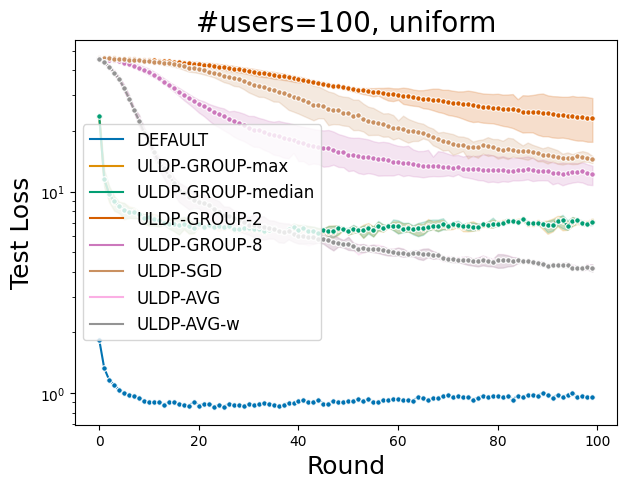

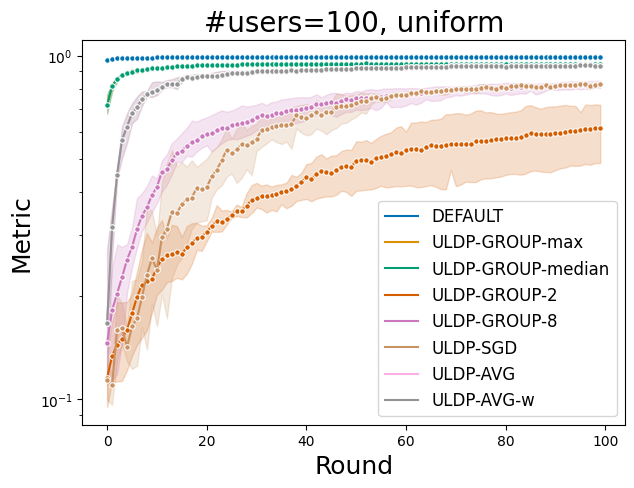

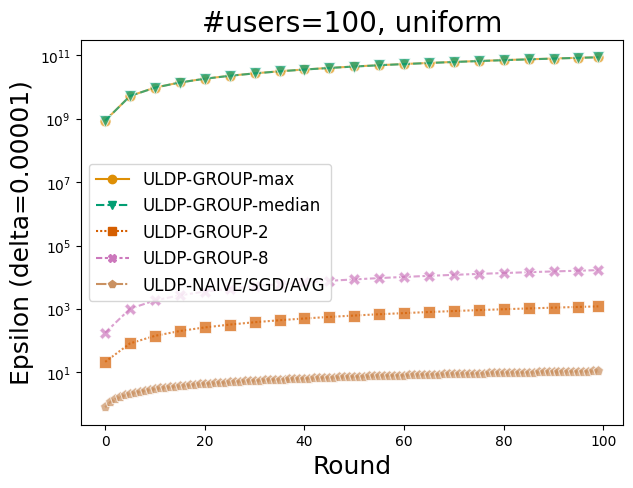

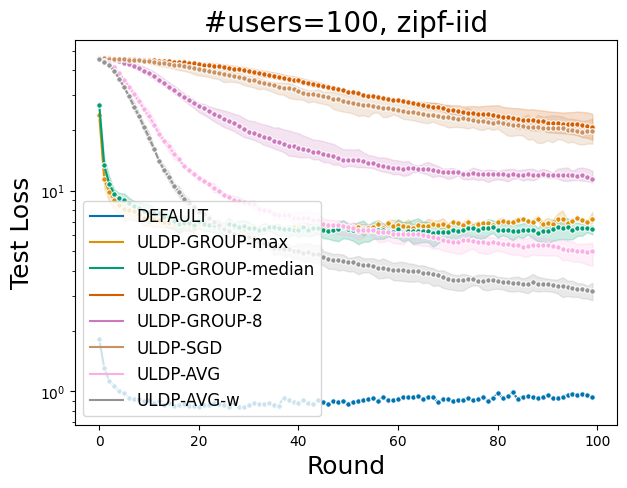

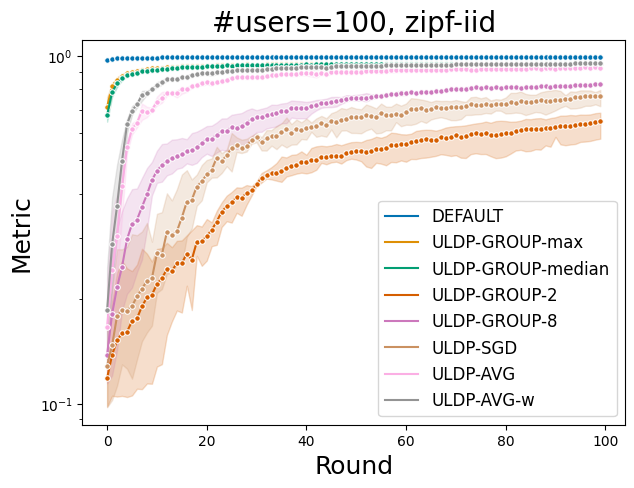

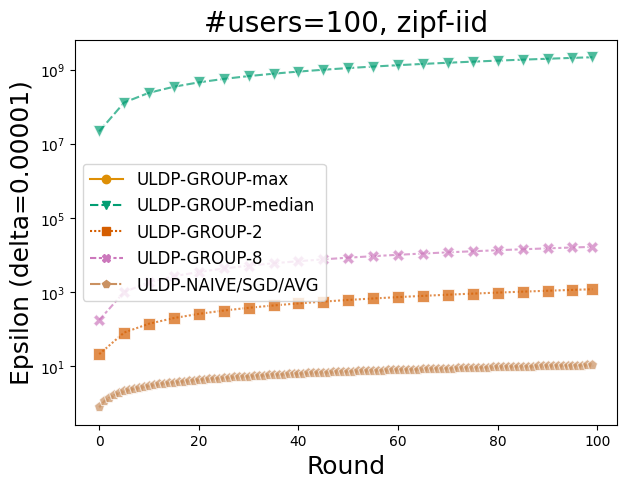

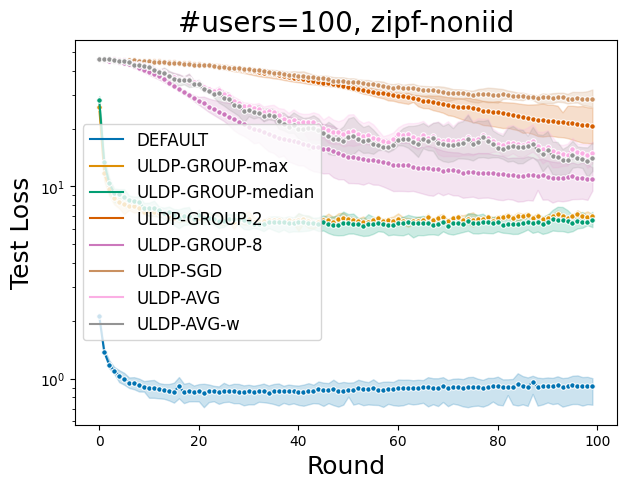

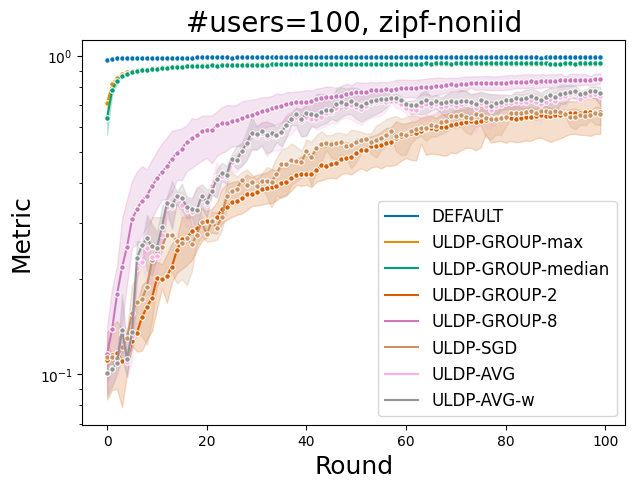

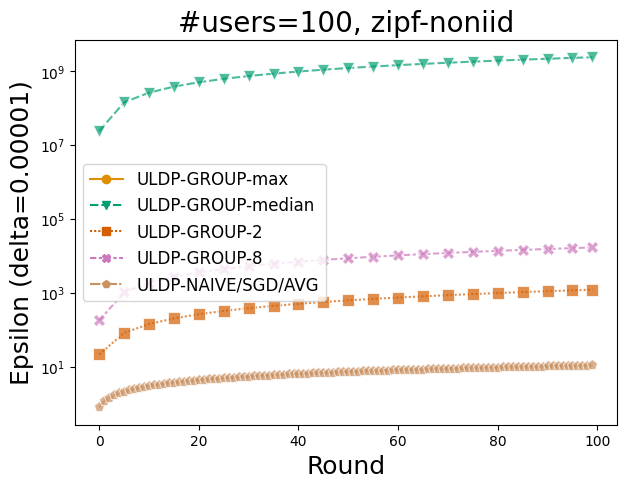

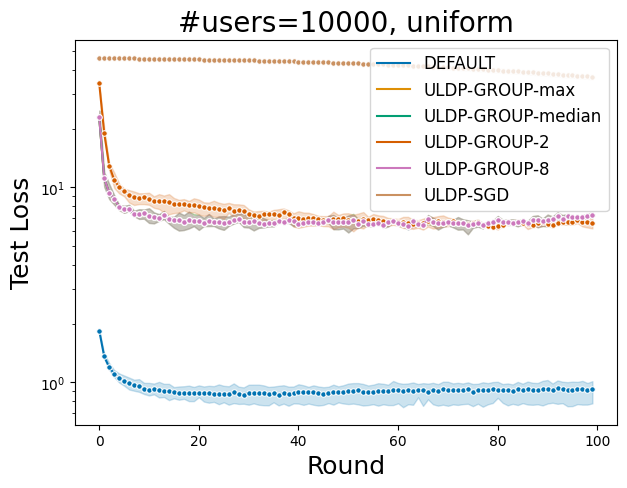

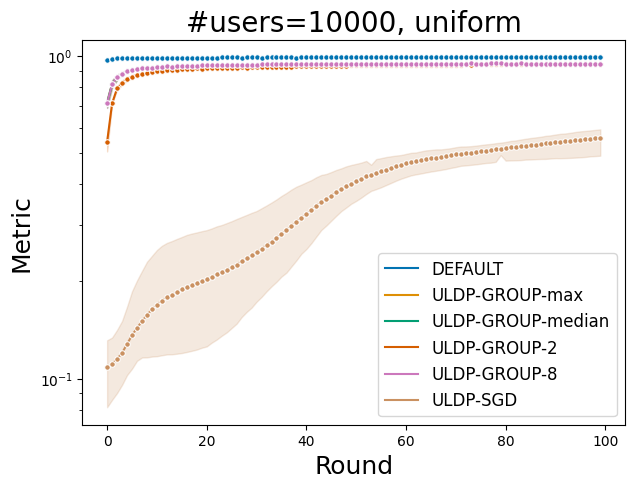

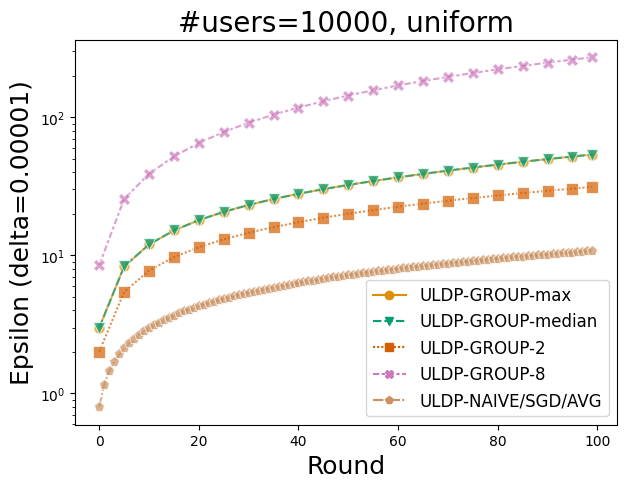

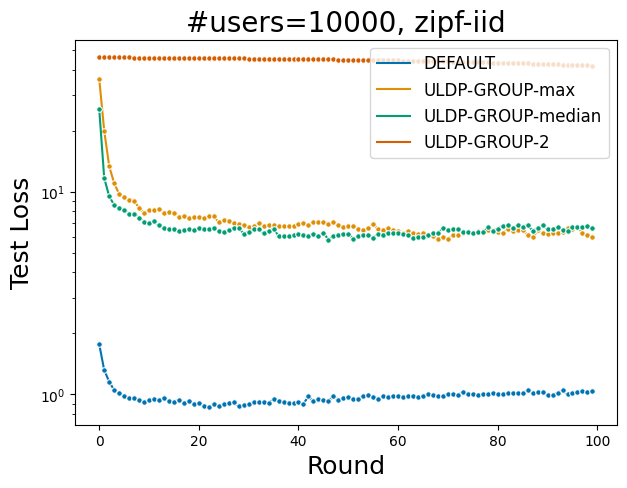

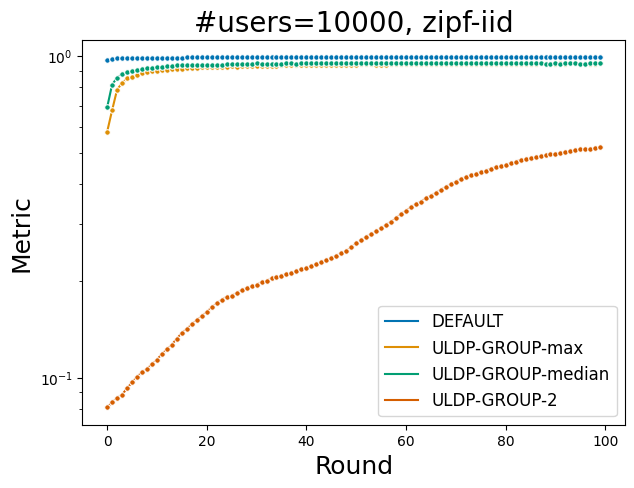

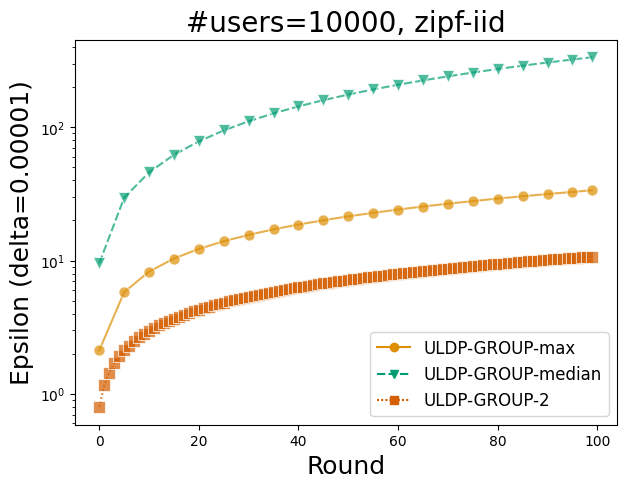

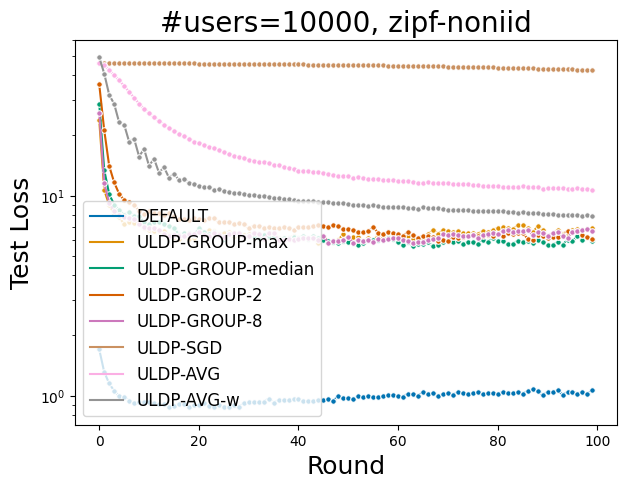

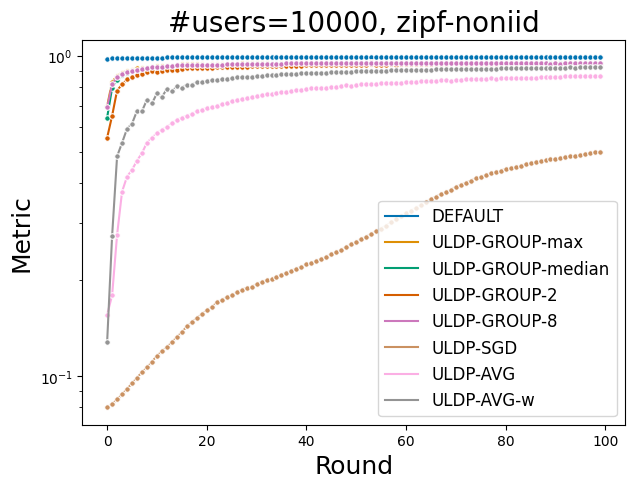

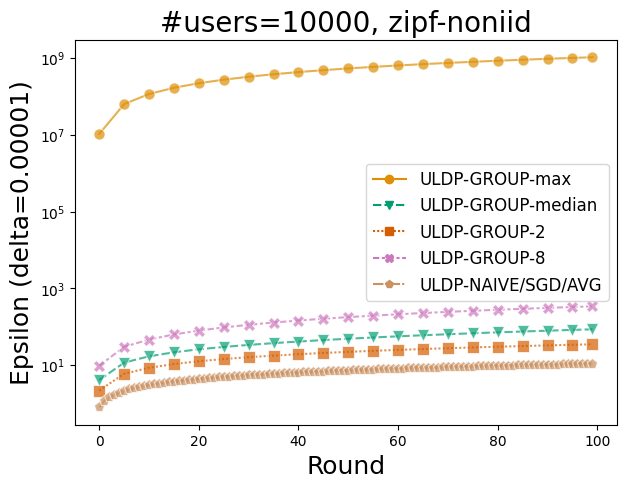

In [42]:
# mnist

n_users_list = [100, 10000]
dist_list = ["uniform", "zipf-iid", "zipf-noniid"]
dataset_name = "mnist"
setting_map = {0: "DEFAULT", 1: "ULDP-GROUP-max", 2: "ULDP-GROUP-median", 3: "ULDP-GROUP-2", 4: "ULDP-GROUP-8", 5: "ULDP-SGD", 6: "ULDP-AVG", 7: "ULDP-AVG-w"}
privacy_setting_map = {0: "DEFAULT", 1: "ULDP-GROUP-max", 2: "ULDP-GROUP-median", 3: "ULDP-GROUP-2", 4: "ULDP-GROUP-8", 5: "ULDP-NAIVE/SGD/AVG", 6: "ULDP-NAIVE/SGD/AVG", 7: "ULDP-NAIVE/SGD/AVG"}
for n_users in n_users_list:
    for user_dist in dist_list:
        target_file_paths = []
        for file_path in privacy_utility_file_paths:
            with open(file_path, "r") as json_file:
                results = json.load(json_file)
            args = results["args"]
            if f"dataset_name='{dataset_name}'" in args and f"n_users={n_users}," in args and f"user_dist='{user_dist}'" in args and  "agg_strategy='ULDP-NAIVE'" not in args:
                target_file_paths.append(file_path)

        plot_multiple_losses(target_file_paths, setting_map, title=f"#users={n_users}, {user_dist}", img_file=f"{img_file_prefix}_{dataset_name}_{n_users}_{user_dist}")
        plot_multiple_metrics(target_file_paths, setting_map, title=f"#users={n_users}, {user_dist}", img_file=f"{img_file_prefix}_{dataset_name}_{n_users}_{user_dist}")
        plot_multiple_epsilons(target_file_paths, privacy_setting_map, title=f"#users={n_users}, {user_dist}", img_file=f"{img_file_prefix}_{dataset_name}_{n_users}_{user_dist}", n_rounds=100)